# **Customer Churn Prediction Project**

**Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold, cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, make_scorer, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
import random

**Load Data**

In [3]:
# Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
filepath = '/content/drive/My Drive/Colab Notebooks/Customer_Churn_Prediction/dataset/Telco-Customer-Churn.csv'
# filepath = 'dataset/Telco-Customer-Churn.csv'
data = pd.read_csv(filepath)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# **1. Data Overview**

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [9]:
# Cleaning Data
data.drop('customerID', axis=1, inplace=True)
data['PaymentMethod'] = data['PaymentMethod'].str.replace(' (automatic)', "", regex=False)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['SeniorCitizen'] = data['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

In [10]:
def get_summary(data):
    column_names = data.columns
    summary = []

    for col in column_names:
        summary.append([col, data[col].unique(), data[col].nunique(), data[col].isnull().sum(), data[col].dtype])

    summary_df = pd.DataFrame(summary, columns=["Column", "Unique Values", "Unique Count", "Null Value", "data type"])
    print("Shape: ", data.shape)
    display(summary_df)

get_summary(data)

Shape:  (7043, 20)


,Column,Unique Values,Unique Count,Null Value,data type
0,gender,"[Female, Male]",2,0,object
1,SeniorCitizen,"[No, Yes]",2,0,object
2,Partner,"[Yes, No]",2,0,object
3,Dependents,"[No, Yes]",2,0,object
4,tenure,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...",73,0,int64
5,PhoneService,"[No, Yes]",2,0,object
6,MultipleLines,"[No phone service, No, Yes]",3,0,object
7,InternetService,"[DSL, Fiber optic, No]",3,0,object
8,OnlineSecurity,"[No, Yes, No internet service]",3,0,object
9,OnlineBackup,"[Yes, No, No internet service]",3,0,object


In [11]:
data[data['TotalCharges'].isnull()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer,52.55,NaN,No
753,Male,No,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,No,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card,56.05,NaN,No
3331,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [ ]:
data.dropna(inplace=True)

In [ ]:
get_summary(data)

Shape:  (7032, 20)


,Column,Unique Values,Unique Count,Null Value,data type
0,gender,"[Female, Male]",2,0,object
1,SeniorCitizen,"[No, Yes]",2,0,object
2,Partner,"[Yes, No]",2,0,object
3,Dependents,"[No, Yes]",2,0,object
4,tenure,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...",72,0,int64
5,PhoneService,"[No, Yes]",2,0,object
6,MultipleLines,"[No phone service, No, Yes]",3,0,object
7,InternetService,"[DSL, Fiber optic, No]",3,0,object
8,OnlineSecurity,"[No, Yes, No internet service]",3,0,object
9,OnlineBackup,"[Yes, No, No internet service]",3,0,object


In [ ]:
data.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


In [ ]:
data.describe(include='object').T

,count,unique,top,freq
gender,7032,2,Male,3549
SeniorCitizen,7032,2,No,5890
Partner,7032,2,No,3639
Dependents,7032,2,No,4933
PhoneService,7032,2,Yes,6352
MultipleLines,7032,3,No,3385
InternetService,7032,3,Fiber optic,3096
OnlineSecurity,7032,3,No,3497
OnlineBackup,7032,3,No,3087
DeviceProtection,7032,3,No,3094


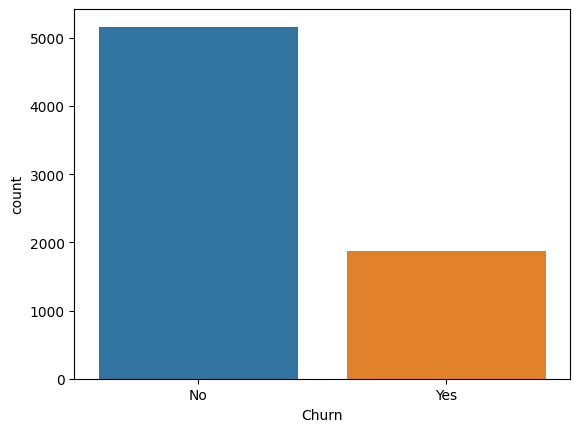

,count
Churn,
No,5163
Yes,1869


In [ ]:
sns.countplot(data=data, x='Churn', hue='Churn')
plt.show()
data['Churn'].value_counts()

**dataset is imbalanced**

# **2. Stratified Data Splitting**



In [ ]:
def split_data(data):
    strat_train_set, strat_test_set = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Churn'])
    print("Training Set")
    print(strat_train_set['Churn'].value_counts()/len(strat_train_set))
    print('-' * 30)
    print("Testing Set")
    print(strat_test_set['Churn'].value_counts()/len(strat_test_set))
    print('-' * 30)

    X_train = strat_train_set.drop('Churn', axis=1)
    y_train = strat_train_set['Churn']
    X_test = strat_test_set.drop('Churn', axis=1)
    y_test = strat_test_set['Churn']

    # Shapes
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_test shape:", y_test.shape)
    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = split_data(data)

cust_churn_df = X_train.copy()
churn_labels = y_train.copy()

Training Set
Churn
No     0.734222
Yes    0.265778
Name: count, dtype: float64
------------------------------
Testing Set
Churn
No     0.734186
Yes    0.265814
Name: count, dtype: float64
------------------------------
X_train shape: (5625, 19)
y_train shape: (5625,)
X_test shape: (1407, 19)
y_test shape: (1407,)


# **3. EDA: Exploratory Data Analysis**

## **3.1 Numeric Features**

In [ ]:
num_features = cust_churn_df.select_dtypes(include='number').columns.to_list()

Number of outliers in tenure: 0
Number of outliers in MonthlyCharges: 0
Number of outliers in TotalCharges: 0


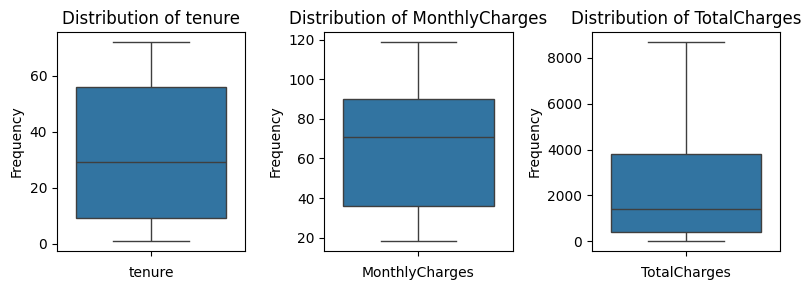

In [ ]:
def detect_outliers_iqr(df, num_features):
    outlier_dict = {}

    for column in num_features:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # lower and upper bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Indices of outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
        outlier_dict[column] = outliers

    for feature, outliers in outlier_dict.items():
        print(f"Number of outliers in {feature}: {len(outliers)}")

    fig, axes = plt.subplots(1, 3, figsize=(8, 3))
    for i, col in enumerate(num_features):
        sns.boxplot(data=df, y=col, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()


detect_outliers_iqr(cust_churn_df, num_features)

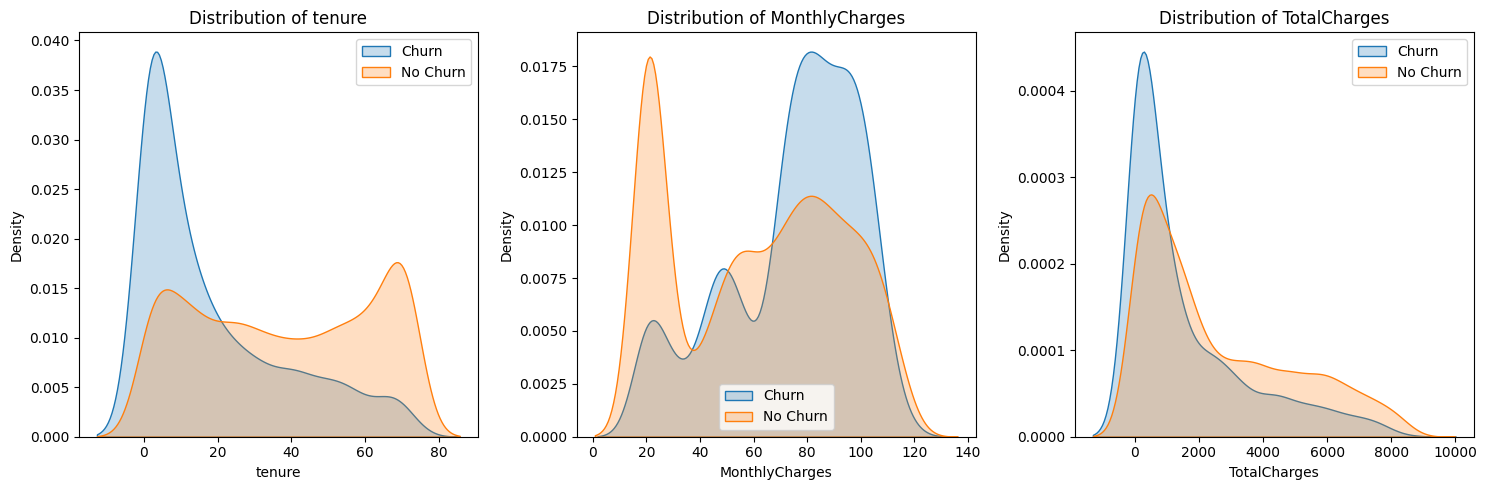

In [ ]:
def kde_plots(cust_churn, features, labels):

    fig = plt.subplots(1, 3, figsize=(15, 5))
    for i, col in enumerate(features):
        plt.subplot(1, 3, i+1)
        sns.kdeplot(cust_churn[col][labels == 'Yes'], label='Churn', fill=True)
        sns.kdeplot(cust_churn[col][labels == 'No'], label='No Churn', fill=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.legend()
    plt.tight_layout()
    return plt.show()

kde_plots(cust_churn_df, num_features, churn_labels)

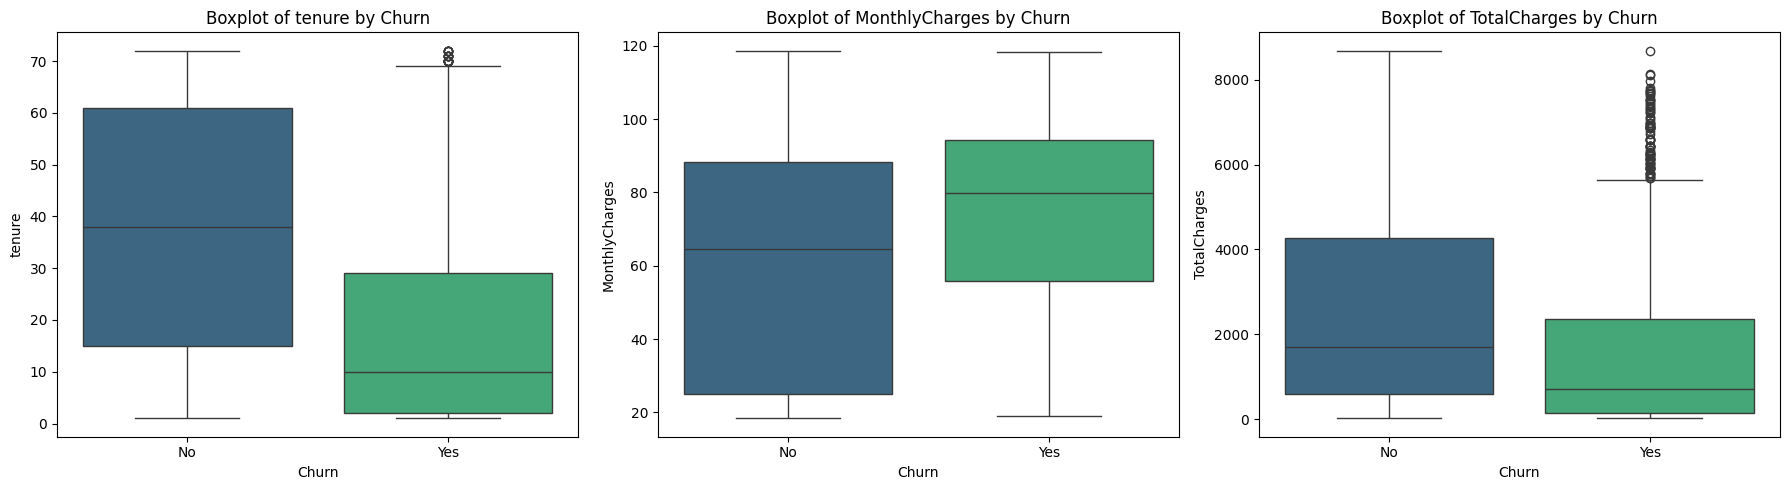

In [ ]:
def boxplot_churn_distribution(cust_churn, features, labels):
    fig = plt.subplots(1, len(features), figsize=(6 * len(features), 5))

    for i, col in enumerate(features):
        plt.subplot(1, len(features), i + 1)
        sns.boxplot(x=labels, y=cust_churn[col], palette='viridis', hue=labels)
        plt.title(f'Boxplot of {col} by Churn')
        plt.xlabel('Churn')
        plt.ylabel(col)

    plt.tight_layout()
    return plt.show()

boxplot_churn_distribution(cust_churn_df, num_features, churn_labels)

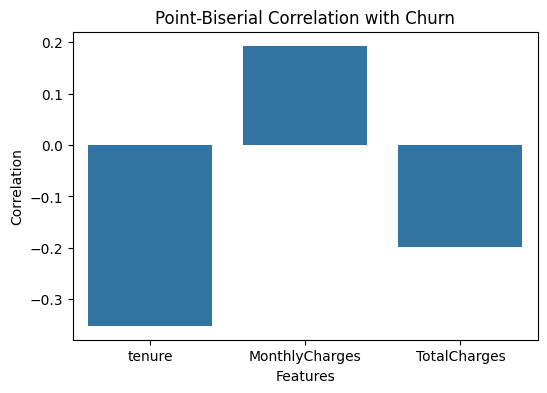

,Feature,PointBiserialCorr,p-value
0,tenure,-0.351710,1.771541e-163
1,MonthlyCharges,0.193455,1.461072e-48
2,TotalCharges,-0.197988,7.984453e-51


In [ ]:
from scipy.stats import pointbiserialr

def compute_point_biserial(df, numeric_features, target_column):
    target_binary = target_column.map({'Yes': 1, 'No': 0})

    results = []
    for feature in numeric_features:
        correlation, p_value = pointbiserialr(df[feature], target_binary)
        results.append({
            'Feature': feature,
            'PointBiserialCorr': correlation,
            'p-value': p_value
        })

    corr_df = pd.DataFrame(results)
    plt.figure(figsize=(6, 4))
    sns.barplot(x='Feature', y='PointBiserialCorr', data=corr_df)
    plt.title('Point-Biserial Correlation with Churn')
    plt.xlabel('Features')
    plt.ylabel('Correlation')
    plt.show()

    return corr_df


corr_df = compute_point_biserial(cust_churn_df, num_features, churn_labels)
corr_df

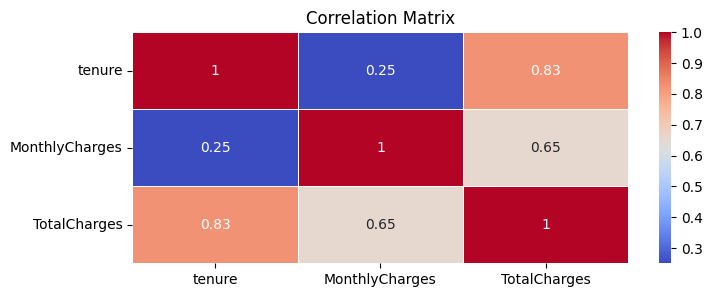

In [ ]:
corr_matrix = cust_churn_df[num_features].corr()
plt.figure(figsize=(8, 3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Observation:  
* All three feature have good relation with target.  
* This suggests that customers with shorter tenures are more likely to churn.  
* Customers who churn tend to have slightly higher MonthlyCharges on average.  
* Customers who churn have significantly lower TotalCharges compared to those who don't churn.  

All Three features seems to be good predictor of target.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    display(vif_data)

In [ ]:
print(vif(cust_churn_df[['tenure', 'MonthlyCharges', 'TotalCharges']]))
print('-' * 50)
print(vif(cust_churn_df[['tenure', 'MonthlyCharges']]))

,Feature,VIF
0,tenure,6.401384
1,MonthlyCharges,3.385962
2,TotalCharges,8.155432


None
--------------------------------------------------


,Feature,VIF
0,tenure,2.638005
1,MonthlyCharges,2.638005


None


TotalCharges is highly Correlated with Tenure, since TotalCharges = MonthlyCharges * Tenure


In [ ]:
def update_feature_log(existing_log, feature_name, reason, additional_info=None):
    existing_log.append({
        'Feature': feature_name,
        'Reason': reason,
        'Additional Info': additional_info
    })
    return existing_log

removeable_features_dict = []

In [ ]:
removeable_features_dict = update_feature_log(removeable_features_dict, 'TotalCharges',
                                              'Highly Correlated with Tenure, VIF = 8.16', 'TotalCharges = MonthlyCharges * Tenure')

In [ ]:
def bucketize_and_plot(cust_churn, feature, q=5, add_to_df=False, plot=True):
    df = cust_churn.copy()

    # Create bucketized feature
    df[feature + "_q_bucketized"], bin_edges = pd.qcut(df[feature], q=q, duplicates="drop", retbins=True)
    bucket_counts = df[feature + "_q_bucketized"].value_counts().sort_index()

    if plot:
        # Plot distribution
        plt.figure(figsize=(8, 4))
        sns.histplot(df[feature], bins=50, kde=True, alpha=0.6, color="blue")

        for edge in bin_edges:
            plt.axvline(edge, color='red', linestyle='dashed', linewidth=1)

        plt.title(f"Bucketized Distribution of {feature}")
        plt.xlabel(feature)
        plt.ylabel("Frequency")
        plt.show()

    # Print bucket counts
    print("\nBucket Counts:")
    for bucket, count in bucket_counts.items():
        print(f"{bucket}: {count} entries")

    # Return modified dataframe if add_to_df is True
    if add_to_df:
        return df, bin_edges
    else:
        return bin_edges

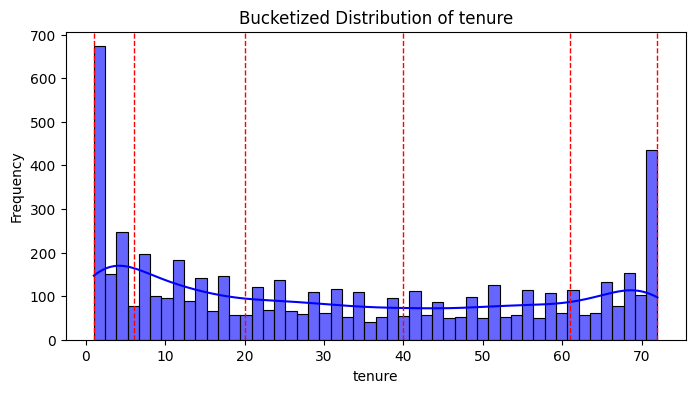


Bucket Counts:
(0.999, 6.0]: 1148 entries
(6.0, 20.0]: 1131 entries
(20.0, 40.0]: 1142 entries
(40.0, 61.0]: 1126 entries
(61.0, 72.0]: 1078 entries
[ 1.  6. 20. 40. 61. 72.]


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure_q_bucketized
1413,Male,No,Yes,Yes,65,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,No,No,Two year,No,Credit card,94.55,6078.75,"(61.0, 72.0]"
7003,Male,No,No,No,26,No,No phone service,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Electronic check,35.75,1022.50,"(20.0, 40.0]"
3355,Female,No,Yes,No,68,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,No,No,Two year,No,Credit card,90.20,6297.65,"(61.0, 72.0]"
4494,Male,No,No,No,3,Yes,No,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,No,Electronic check,84.30,235.05,"(0.999, 6.0]"
3541,Female,No,Yes,No,49,No,No phone service,DSL,Yes,No,No,No,Yes,No,Month-to-month,No,Bank transfer,40.65,2070.75,"(40.0, 61.0]"


In [ ]:
cust_churn_df, bin_edges = bucketize_and_plot(cust_churn_df, 'tenure', q=5, add_to_df=True)
print(bin_edges)
cust_churn_df.head()

In [ ]:
def custom_bucketize(df_, feature, bins, labels):
    df = df_.copy()
    df[feature + "_bins_bucketized"] = pd.cut(df[feature], bins=bins, labels=labels, right=True)
    return df

In [ ]:
bins = [0, 12, 36, 72]
labels = ["New", "Medium", "Long"]
cust_churn_df = custom_bucketize(cust_churn_df, 'tenure', bins, labels)
cust_churn_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure_q_bucketized,tenure_bins_bucketized
1413,Male,No,Yes,Yes,65,Yes,Yes,Fiber optic,Yes,Yes,...,Yes,No,No,Two year,No,Credit card,94.55,6078.75,"(61.0, 72.0]",Long
7003,Male,No,No,No,26,No,No phone service,DSL,No,No,...,Yes,No,No,Month-to-month,No,Electronic check,35.75,1022.50,"(20.0, 40.0]",Medium
3355,Female,No,Yes,No,68,Yes,Yes,Fiber optic,No,Yes,...,Yes,No,No,Two year,No,Credit card,90.20,6297.65,"(61.0, 72.0]",Long
4494,Male,No,No,No,3,Yes,No,Fiber optic,No,Yes,...,No,No,Yes,Month-to-month,No,Electronic check,84.30,235.05,"(0.999, 6.0]",New
3541,Female,No,Yes,No,49,No,No phone service,DSL,Yes,No,...,No,Yes,No,Month-to-month,No,Bank transfer,40.65,2070.75,"(40.0, 61.0]",Long


In [ ]:
def apply_transform_and_plot(cust_churn, feature, transformer):
    df = cust_churn.copy()
    df[feature + "_transformed"] = transformer.transform(df[[feature]])

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    sns.histplot(df[feature], bins=50, kde=True, ax=axes[0])
    axes[0].set_title(f"Original Distribution of {feature}")

    sns.histplot(df[feature + "_transformed"], bins=50, kde=True, ax=axes[1])
    axes[1].set_title(f"Transformed Distribution of {feature}")

    plt.show()

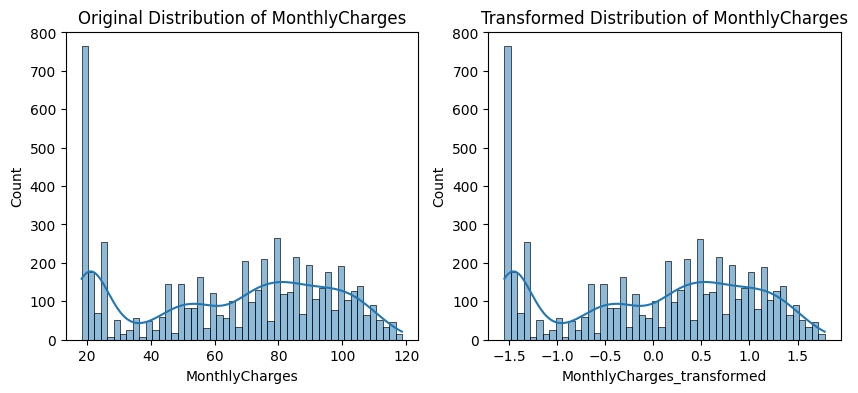

In [ ]:
apply_transform_and_plot(cust_churn_df, 'MonthlyCharges', StandardScaler().fit(cust_churn_df[['MonthlyCharges']]))

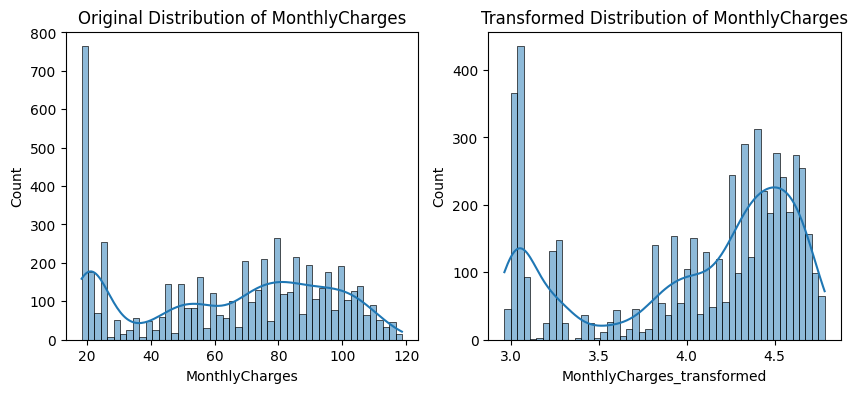

In [ ]:
apply_transform_and_plot(cust_churn_df, 'MonthlyCharges', FunctionTransformer(np.log1p))

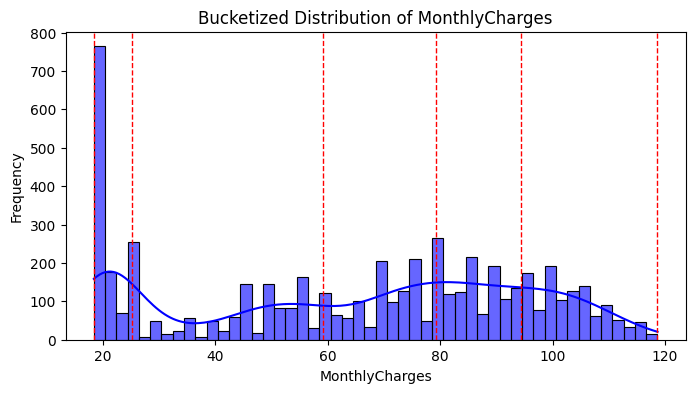


Bucket Counts:
(18.398999999999997, 25.1]: 1136 entries
(25.1, 59.08]: 1114 entries
(59.08, 79.3]: 1129 entries
(79.3, 94.46]: 1121 entries
(94.46, 118.65]: 1125 entries


array([ 18.4 ,  25.1 ,  59.08,  79.3 ,  94.46, 118.65])

In [ ]:
bucketize_and_plot(cust_churn_df, 'MonthlyCharges', q=5)

In [ ]:
cust_churn_df, _b = bucketize_and_plot(cust_churn_df, 'MonthlyCharges', q=5, add_to_df=True, plot=False)
cust_churn_df.head()


Bucket Counts:
(18.398999999999997, 25.1]: 1136 entries
(25.1, 59.08]: 1114 entries
(59.08, 79.3]: 1129 entries
(79.3, 94.46]: 1121 entries
(94.46, 118.65]: 1125 entries


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure_q_bucketized,tenure_bins_bucketized,MonthlyCharges_q_bucketized
1413,Male,No,Yes,Yes,65,Yes,Yes,Fiber optic,Yes,Yes,...,No,No,Two year,No,Credit card,94.55,6078.75,"(61.0, 72.0]",Long,"(94.46, 118.65]"
7003,Male,No,No,No,26,No,No phone service,DSL,No,No,...,No,No,Month-to-month,No,Electronic check,35.75,1022.50,"(20.0, 40.0]",Medium,"(25.1, 59.08]"
3355,Female,No,Yes,No,68,Yes,Yes,Fiber optic,No,Yes,...,No,No,Two year,No,Credit card,90.20,6297.65,"(61.0, 72.0]",Long,"(79.3, 94.46]"
4494,Male,No,No,No,3,Yes,No,Fiber optic,No,Yes,...,No,Yes,Month-to-month,No,Electronic check,84.30,235.05,"(0.999, 6.0]",New,"(79.3, 94.46]"
3541,Female,No,Yes,No,49,No,No phone service,DSL,Yes,No,...,Yes,No,Month-to-month,No,Bank transfer,40.65,2070.75,"(40.0, 61.0]",Long,"(25.1, 59.08]"


In [ ]:
bins = [0, 30, 70, 100, 150]
labels = ["Low", "Medium", "High", "Very High"]
cust_churn_df = custom_bucketize(cust_churn_df, 'MonthlyCharges', bins, labels)
cust_churn_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure_q_bucketized,tenure_bins_bucketized,MonthlyCharges_q_bucketized,MonthlyCharges_bins_bucketized
1413,Male,No,Yes,Yes,65,Yes,Yes,Fiber optic,Yes,Yes,...,No,Two year,No,Credit card,94.55,6078.75,"(61.0, 72.0]",Long,"(94.46, 118.65]",High
7003,Male,No,No,No,26,No,No phone service,DSL,No,No,...,No,Month-to-month,No,Electronic check,35.75,1022.50,"(20.0, 40.0]",Medium,"(25.1, 59.08]",Medium
3355,Female,No,Yes,No,68,Yes,Yes,Fiber optic,No,Yes,...,No,Two year,No,Credit card,90.20,6297.65,"(61.0, 72.0]",Long,"(79.3, 94.46]",High
4494,Male,No,No,No,3,Yes,No,Fiber optic,No,Yes,...,Yes,Month-to-month,No,Electronic check,84.30,235.05,"(0.999, 6.0]",New,"(79.3, 94.46]",High
3541,Female,No,Yes,No,49,No,No phone service,DSL,Yes,No,...,No,Month-to-month,No,Bank transfer,40.65,2070.75,"(40.0, 61.0]",Long,"(25.1, 59.08]",Medium


In [ ]:
print(cust_churn_df.shape)
cust_churn_df.head()

(5625, 23)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure_q_bucketized,tenure_bins_bucketized,MonthlyCharges_q_bucketized,MonthlyCharges_bins_bucketized
1413,Male,No,Yes,Yes,65,Yes,Yes,Fiber optic,Yes,Yes,...,No,Two year,No,Credit card,94.55,6078.75,"(61.0, 72.0]",Long,"(94.46, 118.65]",High
7003,Male,No,No,No,26,No,No phone service,DSL,No,No,...,No,Month-to-month,No,Electronic check,35.75,1022.50,"(20.0, 40.0]",Medium,"(25.1, 59.08]",Medium
3355,Female,No,Yes,No,68,Yes,Yes,Fiber optic,No,Yes,...,No,Two year,No,Credit card,90.20,6297.65,"(61.0, 72.0]",Long,"(79.3, 94.46]",High
4494,Male,No,No,No,3,Yes,No,Fiber optic,No,Yes,...,Yes,Month-to-month,No,Electronic check,84.30,235.05,"(0.999, 6.0]",New,"(79.3, 94.46]",High
3541,Female,No,Yes,No,49,No,No phone service,DSL,Yes,No,...,No,Month-to-month,No,Bank transfer,40.65,2070.75,"(40.0, 61.0]",Long,"(25.1, 59.08]",Medium


## **3.2 Categorical Features**

In [ ]:
# category to object type conversion
feat = cust_churn_df.select_dtypes(include='category').columns.to_list()
for f in feat:
    cust_churn_df[f] = cust_churn_df[f].astype('object')

In [ ]:
get_summary(cust_churn_df)

Shape:  (5625, 23)


,Column,Unique Values,Unique Count,Null Value,data type
0,gender,"[Male, Female]",2,0,object
1,SeniorCitizen,"[No, Yes]",2,0,object
2,Partner,"[Yes, No]",2,0,object
3,Dependents,"[Yes, No]",2,0,object
4,tenure,"[65, 26, 68, 3, 49, 64, 7, 22, 31, 6, 1, 12, 6...",72,0,int64
5,PhoneService,"[Yes, No]",2,0,object
6,MultipleLines,"[Yes, No phone service, No]",3,0,object
7,InternetService,"[Fiber optic, DSL, No]",3,0,object
8,OnlineSecurity,"[Yes, No, No internet service]",3,0,object
9,OnlineBackup,"[Yes, No, No internet service]",3,0,object


In [ ]:
from scipy.stats import chi2_contingency

def barplot_and_perform_chi2_test(cust_churn, features, labels):
    less_imp_feat = []
    n = len(features)
    rows = (n + 2) // 3
    cols = min(n, 3)
    fig_width = 5 * cols
    fig_height = 4 * rows
    fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height))
    axes = axes.flatten()
    for i, col in enumerate(features):
        sns.countplot(data=cust_churn, x=col, hue=labels, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()


    for col in features:
        contingency_table = pd.crosstab(cust_churn[col], labels)
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)

        print(f"Chi-Square Test for {col}:")
        print(f"Chi-Square Statistic = {chi2:.2f}, p-value = {p_value:.5f}")

        alpha = 0.05
        if p_value < alpha:
            print("Reject the null hypothesis: There is a significant relationship.")
        else:
            print("Fail to reject the null hypothesis: No significant relationship.")
            less_imp_feat.append(col)

        print("-" * 50)

    return less_imp_feat

In [ ]:
cat_features = cust_churn_df.select_dtypes(include='object').columns.to_list()
print(len(cat_features))
cat_features

20


['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'tenure_q_bucketized',
 'tenure_bins_bucketized',
 'MonthlyCharges_q_bucketized',
 'MonthlyCharges_bins_bucketized']

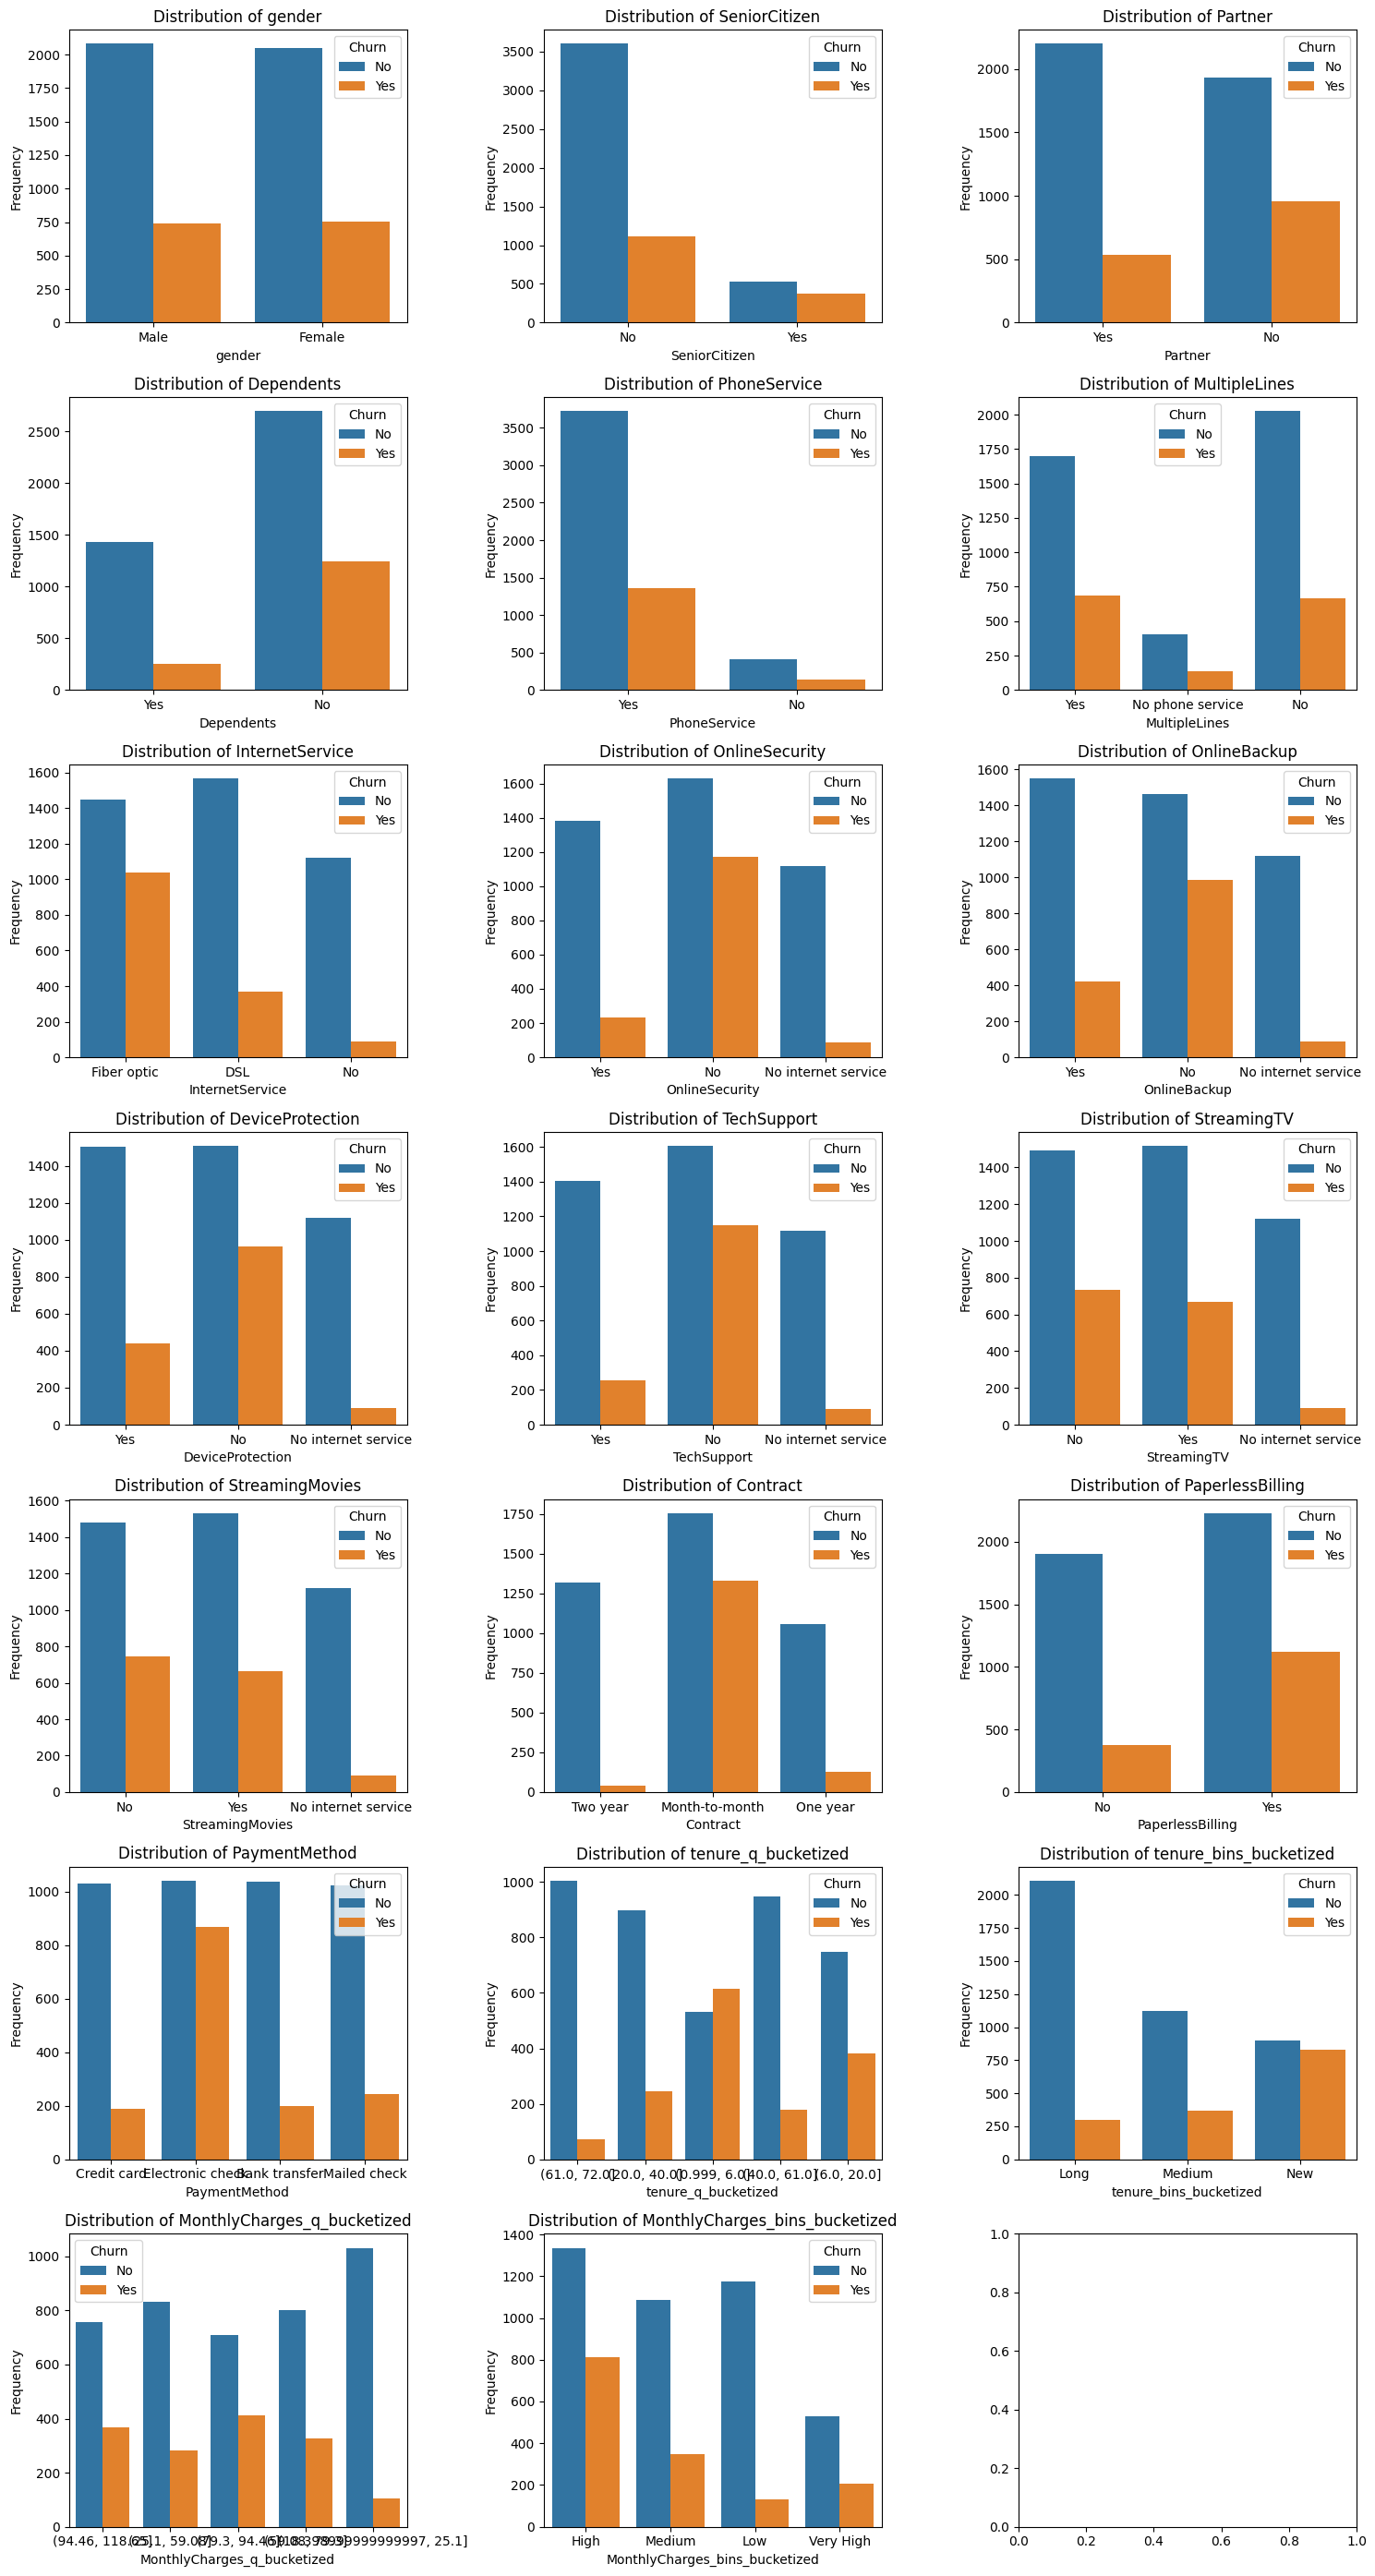

Chi-Square Test for gender:
Chi-Square Statistic = 0.17, p-value = 0.68186
Fail to reject the null hypothesis: No significant relationship.
--------------------------------------------------
Chi-Square Test for SeniorCitizen:
Chi-Square Statistic = 127.28, p-value = 0.00000
Reject the null hypothesis: There is a significant relationship.
--------------------------------------------------
Chi-Square Test for Partner:
Chi-Square Statistic = 133.23, p-value = 0.00000
Reject the null hypothesis: There is a significant relationship.
--------------------------------------------------
Chi-Square Test for Dependents:
Chi-Square Statistic = 163.98, p-value = 0.00000
Reject the null hypothesis: There is a significant relationship.
--------------------------------------------------
Chi-Square Test for PhoneService:
Chi-Square Statistic = 0.42, p-value = 0.51710
Fail to reject the null hypothesis: No significant relationship.
--------------------------------------------------
Chi-Square Test for M

In [ ]:
less_imp_feat = barplot_and_perform_chi2_test(cust_churn_df, cat_features, churn_labels)
print('Feature to Remove:', less_imp_feat)

In [ ]:
removeable_features_dict = update_feature_log(removeable_features_dict,
                                              'gender', 'Chi-square test (p-value = 0.68186): No significant relationship with target')
removeable_features_dict = update_feature_log(removeable_features_dict,
                                              'PhoneService', 'Chi-square test (p-value = 0.5171): No significant relationship with target')

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

def plot_mi_bars(df, features, label, threshold=0.05):

    encoded_df = df.copy()
    label_encoder = LabelEncoder()
    encoded_label = label_encoder.fit_transform(label)

    for feature in features:
        encoded_df[feature] = label_encoder.fit_transform(df[feature])

    # Compute Mutual Information scores
    mi_scores = mutual_info_classif(encoded_df[features], encoded_label, discrete_features=True)

    # Convert to DataFrame for better visualization
    mi_df = pd.DataFrame({'Feature': features, 'MI Score': mi_scores})
    mi_df = mi_df.sort_values(by="MI Score", ascending=False)

    # Plot bar chart
    plt.figure(figsize=(12, 6))
    sns.barplot(x="MI Score", y="Feature", data=mi_df)
    plt.xlabel("Mutual Information Score")
    plt.ylabel("Categorical Features")
    plt.title("Mutual Information Scores for Categorical Features")
    plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
    plt.show()

    less_imp_feat = mi_df[mi_df["MI Score"] < threshold]["Feature"].tolist()
    print(f"Removeable Features (MI < {threshold}): {less_imp_feat}")

    return less_imp_feat

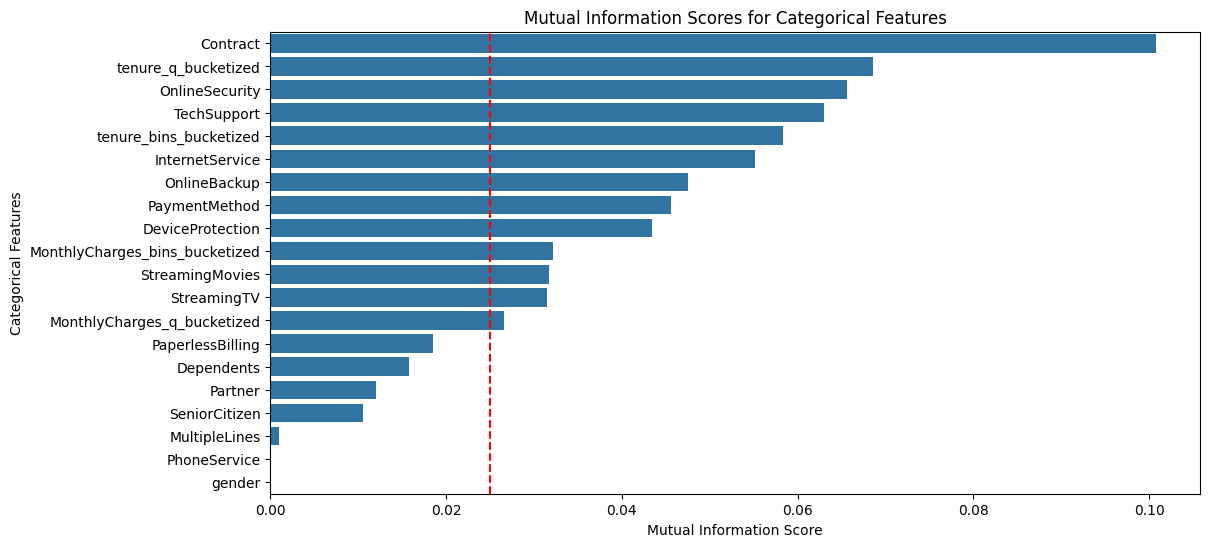

Removeable Features (MI < 0.025): ['PaperlessBilling', 'Dependents', 'Partner', 'SeniorCitizen', 'MultipleLines', 'PhoneService', 'gender']


In [ ]:
less_imp_feat = plot_mi_bars(cust_churn_df, cat_features, churn_labels, threshold=0.025)

In [ ]:
removeable_features_dict = update_feature_log(removeable_features_dict,
                                              less_imp_feat, 'Mutual Information with target < 0.025: Low relevance')

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# Function to calculate Mutual Information (MI) between categorical features and plot heatmap
def plot_mi_heatmap_for_categorical(data, features):
    df = data.copy()
    df = df[features]  # Keep only selected categorical features
    le = LabelEncoder()

    # Encode categorical features
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = le.fit_transform(df[column])

    # Create an empty dataframe to store MI values
    mi = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)

    # Calculate mutual information for each pair of categorical features
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 != col2:  # Skip diagonal (self MI)
                # Since both are categorical, we use mutual_info_classif
                mi_score = mutual_info_classif(df[[col2]], df[col1])
                mi.loc[col1, col2] = mi_score[0]  # Store MI value

    # Convert MI dataframe to a numeric matrix
    mi_values = mi.astype(float)

    # Create a mask to show only the upper triangle (to avoid repetition)
    mask = np.triu(np.ones_like(mi_values, dtype=bool))

    # Plot the heatmap
    plt.figure(figsize=(16, 8))
    sns.heatmap(mi_values, annot=True, cmap="coolwarm", mask=mask, vmin=0, vmax=1)
    plt.title("Mutual Information Heatmap for Categorical Features")
    plt.show()

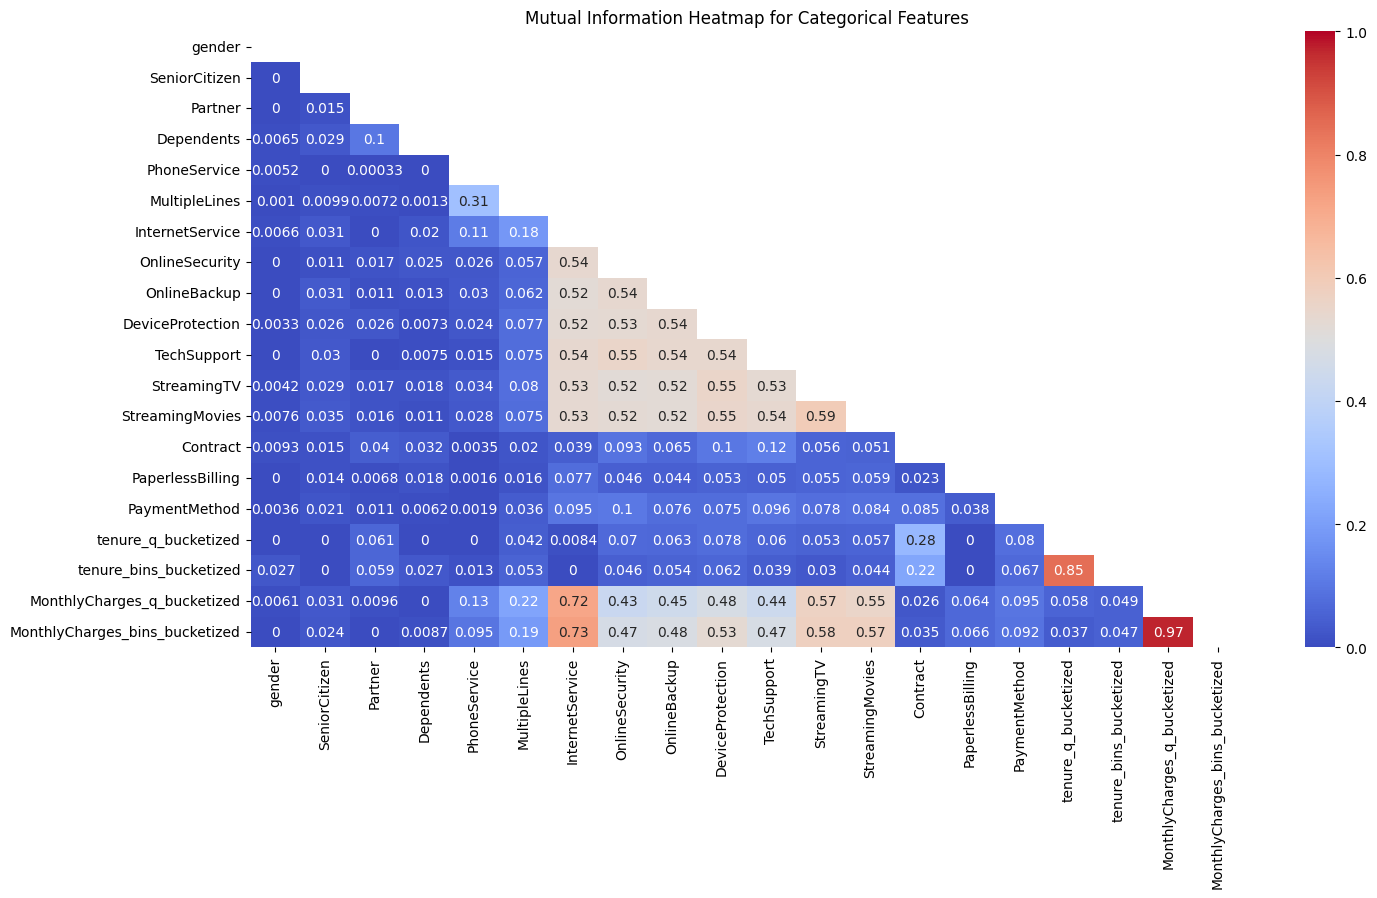

In [ ]:
plot_mi_heatmap_for_categorical(cust_churn_df, cat_features)

In [ ]:
removeable_features_dict = update_feature_log(removeable_features_dict,
                                              'MonthlyCharges_q_bucketized',
                                              'High MI = 0.97 with MonthlyCharges_bins_bucketized', 'Redundant')
removeable_features_dict = update_feature_log(removeable_features_dict,
                                              'tenure_q_bucketized',
                                              'High MI = 0.84 with tenure_bins_bucketized', 'Redundant')
removeable_features_dict = update_feature_log(removeable_features_dict,
                                              'InternetService',
                                              'High MI = 0.75, 0.71 with MonthlyCharges_bins_bucketized, MonthlyCharges_q_bucketized'
                                              'Redundant')

In [ ]:
def cramers_v(x, y):
    # Create contingency table
    contingency_table = pd.crosstab(x, y)

    # Calculate Chi-squared statistic, p-value, degrees of freedom, and expected frequencies
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Calculate Cramér's V
    n = contingency_table.sum().sum()  # Total number of observations
    min_dim = min(contingency_table.shape) - 1  # Min dimension: (rows - 1) or (columns - 1)
    return np.sqrt(chi2 / (n * min_dim))

# Function to calculate and plot Cramér's V heatmap for categorical features
def plot_cramers_v_heatmap_for_categorical(data, features):
    df = data.copy()
    df = df[features]  # Keep only selected categorical features

    # Create an empty dataframe to store Cramér's V values
    cramers_v_df = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)

    # Calculate Cramér's V for each pair of categorical features
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 != col2:  # Skip diagonal (self comparison)
                # Calculate Cramér's V between col1 and col2
                cramers_v_score = cramers_v(df[col1], df[col2])
                cramers_v_df.loc[col1, col2] = cramers_v_score  # Store Cramér's V value

    # Convert Cramér's V dataframe to a numeric matrix
    cramers_v_values = cramers_v_df.astype(float)

    # Create a mask to show only the upper triangle (to avoid repetition)
    mask = np.triu(np.ones_like(cramers_v_values, dtype=bool))

    # Plot the heatmap
    plt.figure(figsize=(16, 8))
    sns.heatmap(cramers_v_values, annot=True, cmap="coolwarm", mask=mask, vmin=0, vmax=1)
    plt.title("Cramér's V Heatmap for Categorical Features")
    plt.show()

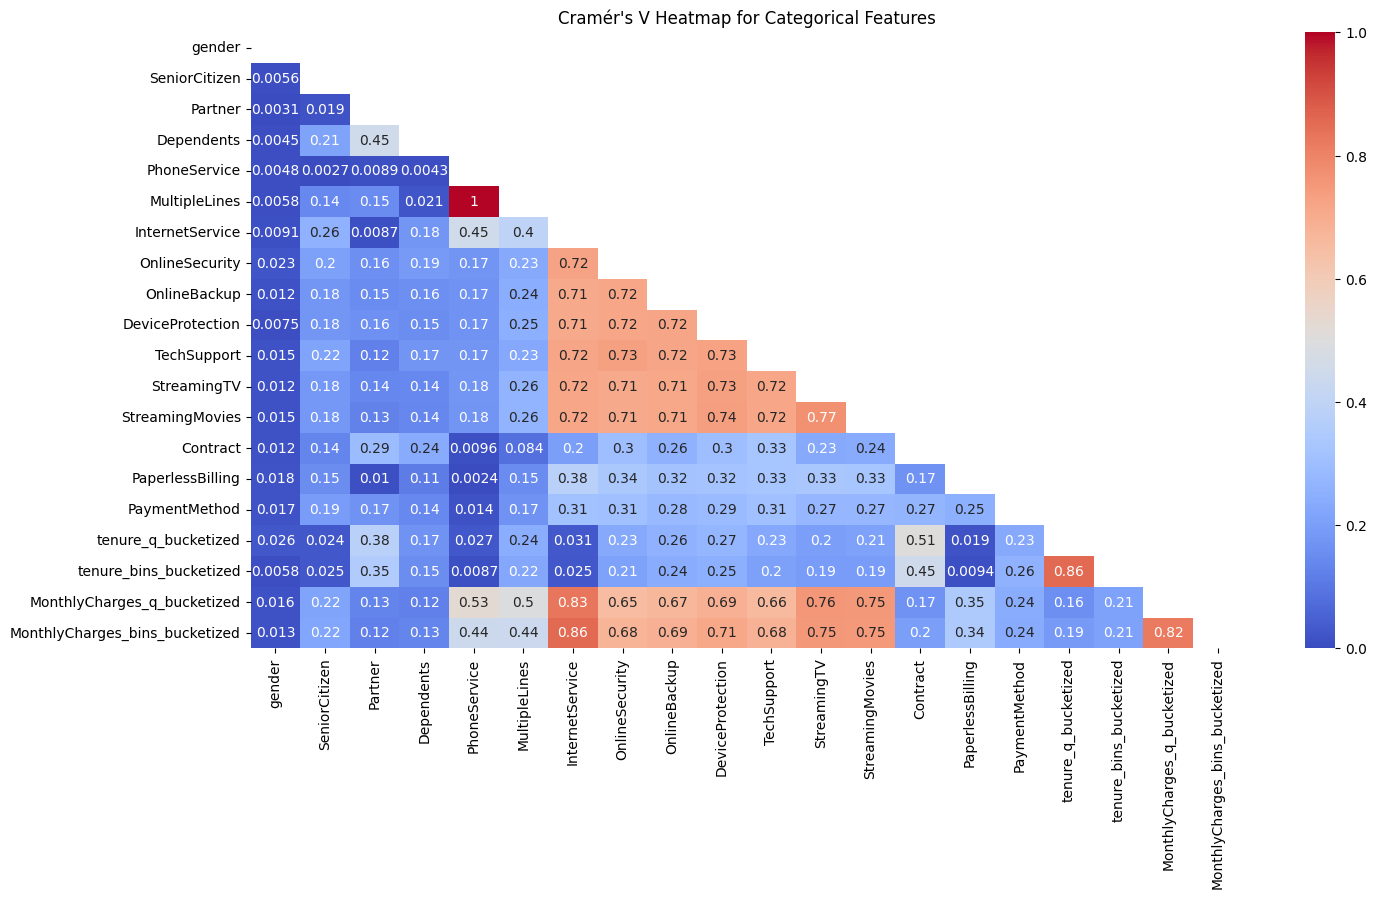

In [ ]:
plot_cramers_v_heatmap_for_categorical(cust_churn_df, cat_features)

In [ ]:
removeable_features_dict = update_feature_log(removeable_features_dict,
                                              'MonthlyCharges_q_bucketized',
                                              'High Cramer\'s V = 0.82 with MonthlyCharges_bins_bucketized',
                                              'Redundant')
removeable_features_dict = update_feature_log(removeable_features_dict,
                                              'tenure_q_bucketized',
                                              'High Cramer\'s V = 0.86 with tenure_bins_bucketized',
                                              'Redundant')
removeable_features_dict = update_feature_log(removeable_features_dict,
                                              'InternetService',
                                              'High Cramer\'s V = 0.86 with MonthlyCharges_bins_bucketized',
                                              'Redundant')
removeable_features_dict = update_feature_log(removeable_features_dict,
                                              'PhoneService',
                                              'High Cramer\'s V = 1 with MultipleLines',
                                              'Redundant')

In [ ]:
get_summary(cust_churn_df)

Shape:  (5625, 23)


,Column,Unique Values,Unique Count,Null Value,data type
0,gender,"[Male, Female]",2,0,object
1,SeniorCitizen,"[No, Yes]",2,0,object
2,Partner,"[Yes, No]",2,0,object
3,Dependents,"[Yes, No]",2,0,object
4,tenure,"[65, 26, 68, 3, 49, 64, 7, 22, 31, 6, 1, 12, 6...",72,0,int64
5,PhoneService,"[Yes, No]",2,0,object
6,MultipleLines,"[Yes, No phone service, No]",3,0,object
7,InternetService,"[Fiber optic, DSL, No]",3,0,object
8,OnlineSecurity,"[Yes, No, No internet service]",3,0,object
9,OnlineBackup,"[Yes, No, No internet service]",3,0,object


**One Hot Encoding**

In [ ]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(cust_churn_df[['Contract']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out())
encoded_df.head()

,Contract_Month-to-month,Contract_One year,Contract_Two year
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


**OrdinalEncoder**

In [ ]:
Oe = OrdinalEncoder(categories=[['Low', 'Medium', 'High', 'Very High']])
df_encoded = Oe.fit_transform(cust_churn_df[['MonthlyCharges_bins_bucketized']])
df_encoded = pd.DataFrame(df_encoded, columns=['MonthlyCharges_bins_bucketized'], index=cust_churn_df.index)
display(cust_churn_df['MonthlyCharges_bins_bucketized'].value_counts())
display(df_encoded.value_counts())

,count
MonthlyCharges_bins_bucketized,
High,2149
Medium,1434
Low,1305
Very High,737


,count
MonthlyCharges_bins_bucketized,
2.0,2149
1.0,1434
0.0,1305
3.0,737


**Standard Scaler**

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(cust_churn_df[num_features])
df_scaled = pd.DataFrame(df_scaled, columns=num_features)
df_scaled.head()

,tenure,MonthlyCharges,TotalCharges
0,1.321816,0.981556,1.659900
1,-0.267410,-0.971546,-0.562252
2,1.444064,0.837066,1.756104
3,-1.204646,0.641092,-0.908326
4,0.669826,-0.808787,-0.101561


# **4. Prepare Data**

In [ ]:
X_train, y_train, X_test, y_test = split_data(data=data)

Training Set
Churn
No     0.734222
Yes    0.265778
Name: count, dtype: float64
------------------------------
Testing Set
Churn
No     0.734186
Yes    0.265814
Name: count, dtype: float64
------------------------------
X_train shape: (5625, 19)
y_train shape: (5625,)
X_test shape: (1407, 19)
y_test shape: (1407,)


In [ ]:
bin_edges = bucketize_and_plot(X_train, 'tenure', q=5, add_to_df=False, plot=False)
print(bin_edges)


Bucket Counts:
(0.999, 6.0]: 1148 entries
(6.0, 20.0]: 1131 entries
(20.0, 40.0]: 1142 entries
(40.0, 61.0]: 1126 entries
(61.0, 72.0]: 1078 entries
[ 1.  6. 20. 40. 61. 72.]


In [ ]:
X_train, bin_edges = bucketize_and_plot(X_train, 'tenure', q=5, add_to_df=True, plot=False)
X_test['tenure_q_bucketized'] = pd.cut(
    X_test['tenure'],
    bins=bin_edges,
    include_lowest=True
)

label_map = {
    pd.Interval(0.999, 6.0, closed='right'): '0_6',
    pd.Interval(6.0, 20.0, closed='right'): '6_20',
    pd.Interval(20.0, 40.0, closed='right'): '20_40',
    pd.Interval(40.0, 61.0, closed='right'): '40_61',
    pd.Interval(61.0, 72.0, closed='right'): '61_72'
}

X_train['tenure_q_bucketized'] = X_train['tenure_q_bucketized'].map(label_map)
X_test['tenure_q_bucketized'] = X_test['tenure_q_bucketized'].map(label_map)


Bucket Counts:
(0.999, 6.0]: 1148 entries
(6.0, 20.0]: 1131 entries
(20.0, 40.0]: 1142 entries
(40.0, 61.0]: 1126 entries
(61.0, 72.0]: 1078 entries


In [ ]:
bin_edges = bucketize_and_plot(X_train, 'MonthlyCharges', q=5, add_to_df=False, plot=False)
bin_edges


Bucket Counts:
(18.398999999999997, 25.1]: 1136 entries
(25.1, 59.08]: 1114 entries
(59.08, 79.3]: 1129 entries
(79.3, 94.46]: 1121 entries
(94.46, 118.65]: 1125 entries


array([ 18.4 ,  25.1 ,  59.08,  79.3 ,  94.46, 118.65])

In [ ]:
X_train, bin_edges = bucketize_and_plot(X_train, 'MonthlyCharges', q=5, add_to_df=True, plot=False)
X_test['MonthlyCharges_q_bucketized'] = pd.cut(
    X_test['MonthlyCharges'],
    bins=bin_edges,
    include_lowest=True
)

label_map = {
    pd.Interval(18.398999999999997, 25.1, closed='right'): '18_25',
    pd.Interval(25.1, 59.08, closed='right'): '25_59',
    pd.Interval(59.08, 79.3, closed='right'): '59_79',
    pd.Interval(79.3, 94.46, closed='right'): '79_94',
    pd.Interval(94.46, 118.65, closed='right'): '94_118'
}


X_train['MonthlyCharges_q_bucketized'] = X_train['MonthlyCharges_q_bucketized'].map(label_map)
X_test['MonthlyCharges_q_bucketized'] = X_test['MonthlyCharges_q_bucketized'].map(label_map)


Bucket Counts:
(18.398999999999997, 25.1]: 1136 entries
(25.1, 59.08]: 1114 entries
(59.08, 79.3]: 1129 entries
(79.3, 94.46]: 1121 entries
(94.46, 118.65]: 1125 entries


In [ ]:
bins = [0, 12, 36, 72]
labels = ["New", "Medium", "Long"]
X_train = custom_bucketize(X_train, 'tenure', bins, labels)
X_test = custom_bucketize(X_test, 'tenure', bins, labels)

bins = [0, 30, 70, 100, 150]
labels = ["Low", "Medium", "High", "Very High"]
X_train = custom_bucketize(X_train, 'MonthlyCharges', bins, labels)
X_test = custom_bucketize(X_test, 'MonthlyCharges', bins, labels)

def update_feature(X):
    feat = X.select_dtypes(include='category').columns.to_list()
    for f in feat:
        X[f] = X[f].astype('object')
    return X

X_train = update_feature(X_train)
X_test = update_feature(X_test)

In [ ]:
get_summary(X_train)

Shape:  (5625, 23)


,Column,Unique Values,Unique Count,Null Value,data type
0,gender,"[Male, Female]",2,0,object
1,SeniorCitizen,"[No, Yes]",2,0,object
2,Partner,"[Yes, No]",2,0,object
3,Dependents,"[Yes, No]",2,0,object
4,tenure,"[65, 26, 68, 3, 49, 64, 7, 22, 31, 6, 1, 12, 6...",72,0,int64
5,PhoneService,"[Yes, No]",2,0,object
6,MultipleLines,"[Yes, No phone service, No]",3,0,object
7,InternetService,"[Fiber optic, DSL, No]",3,0,object
8,OnlineSecurity,"[Yes, No, No internet service]",3,0,object
9,OnlineBackup,"[Yes, No, No internet service]",3,0,object


In [ ]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure_q_bucketized,MonthlyCharges_q_bucketized,tenure_bins_bucketized,MonthlyCharges_bins_bucketized
1413,Male,No,Yes,Yes,65,Yes,Yes,Fiber optic,Yes,Yes,...,No,Two year,No,Credit card,94.55,6078.75,61_72,94_118,Long,High
7003,Male,No,No,No,26,No,No phone service,DSL,No,No,...,No,Month-to-month,No,Electronic check,35.75,1022.50,20_40,25_59,Medium,Medium
3355,Female,No,Yes,No,68,Yes,Yes,Fiber optic,No,Yes,...,No,Two year,No,Credit card,90.20,6297.65,61_72,79_94,Long,High
4494,Male,No,No,No,3,Yes,No,Fiber optic,No,Yes,...,Yes,Month-to-month,No,Electronic check,84.30,235.05,0_6,79_94,New,High
3541,Female,No,Yes,No,49,No,No phone service,DSL,Yes,No,...,No,Month-to-month,No,Bank transfer,40.65,2070.75,40_61,25_59,Long,Medium


## **4.1 Save Data**

In [ ]:
# Mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

path = '/content/drive/MyDrive/Colab Notebooks/Customer_Churn_Prediction/dataset/'
# Create directory if it doesn't exist
os.makedirs(path, exist_ok=True)

X_train.to_csv(f'{path}X_train.csv', index=False)
X_test.to_csv(f'{path}X_test.csv', index=False)
y_train.to_frame(name='Churn').to_csv(f'{path}y_train.csv', index=False)
y_test.to_frame(name='Churn').to_csv(f'{path}y_test.csv', index=False)
print('Done')

Done


## **4.2 Load Data**

In [33]:
def load_data():
    path = '/content/drive/MyDrive/Colab Notebooks/Customer_Churn_Prediction/dataset/'
    # path = 'dataset/'

    X_train = pd.read_csv(f'{path}X_train.csv')
    X_test = pd.read_csv(f'{path}X_test.csv')
    y_train = pd.read_csv(f'{path}y_train.csv')['Churn']
    y_test = pd.read_csv(f'{path}y_test.csv')['Churn']

    # Convert target to 0/1
    y_train = y_train.map({'No': 0, 'Yes': 1})
    y_test = y_test.map({'No': 0, 'Yes': 1})

    # Shapes
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = load_data()

X_train shape: (5625, 23)
y_train shape: (5625,)
X_test shape: (1407, 23)
y_test shape: (1407,)


In [13]:
get_summary(X_train)

Shape:  (5625, 23)


,Column,Unique Values,Unique Count,Null Value,data type
0,gender,"[Male, Female]",2,0,object
1,SeniorCitizen,"[No, Yes]",2,0,object
2,Partner,"[Yes, No]",2,0,object
3,Dependents,"[Yes, No]",2,0,object
4,tenure,"[65, 26, 68, 3, 49, 64, 7, 22, 31, 6, 1, 12, 6...",72,0,int64
5,PhoneService,"[Yes, No]",2,0,object
6,MultipleLines,"[Yes, No phone service, No]",3,0,object
7,InternetService,"[Fiber optic, DSL, No]",3,0,object
8,OnlineSecurity,"[Yes, No, No internet service]",3,0,object
9,OnlineBackup,"[Yes, No, No internet service]",3,0,object


# **5. Preprocessing Pipeline**

In [14]:
num_features = X_train.select_dtypes(include='number').columns.to_list()
cat_features = X_train.select_dtypes(include='object').columns.to_list()

print(f"Numerical Features ({len(num_features)}):\n{num_features}\n")
print(f"Categorical Features ({len(cat_features)}):\n{cat_features}\n")
print(f"All Dataset Columns ({X_train.shape[1]}):\n{X_train.columns.to_list()}\n")

Numerical Features (3):
['tenure', 'MonthlyCharges', 'TotalCharges']

Categorical Features (20):
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_q_bucketized', 'MonthlyCharges_q_bucketized', 'tenure_bins_bucketized', 'MonthlyCharges_bins_bucketized']

All Dataset Columns (23):
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'tenure_q_bucketized', 'MonthlyCharges_q_bucketized', 'tenure_bins_bucketized', 'MonthlyCharges_bins_bucketized']



In [15]:
def create_log_scale_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(np.log1p, feature_names_out='one-to-one'),
        StandardScaler()
    )

def create_1H_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    )

def create_ordinal_pipeline(categories):
    return make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        OrdinalEncoder(categories=categories, handle_unknown='use_encoded_value', unknown_value=-1)
    )

def create_num_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        StandardScaler()
    )

In [16]:
def create_preprocessing_pipeline(
    num_features_scale,
    num_features_log_scale,
    cat_1h_features,
    cat_ordinal_features,
    cat_ordinal_orders=None
):

    transformers = []

    # Standard scaled numeric features
    for f in num_features_scale:
        transformers.append((f'{f}-std_scale', create_num_pipeline(), [f]))

    # Log scaled numeric features
    for f in num_features_log_scale:
        transformers.append((f'{f}-log', create_log_scale_pipeline(), [f]))

    # One-hot encoded categorical features
    for f in cat_1h_features:
        transformers.append((f'{f}-', create_1H_pipeline(), [f]))

    # Ordinal encoded features (custom ordering can be added if needed)
    for f in cat_ordinal_features:
        # Check if custom order exists for this feature
        if f in cat_ordinal_orders:
            categories = [cat_ordinal_orders[f]]  # Use the custom order
        else:
            categories = 'auto'  # Default to auto-detection if no custom order
        transformers.append((f'{f}-ord', create_ordinal_pipeline(categories=categories), [f]))

    # Combine all into a ColumnTransformer
    preprocessing_pipeline = ColumnTransformer(
        transformers=transformers,
        remainder='drop'
    )
    preprocessing_pipeline.set_output(transform='pandas')

    return preprocessing_pipeline

In [17]:
num_f_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']
num_f_log_scale = ['MonthlyCharges', 'TotalCharges']
cat_f_1h = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
            'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod', 'MonthlyCharges_q_bucketized', 'tenure_q_bucketized']
cat_f_ord = ['tenure_bins_bucketized', 'MonthlyCharges_bins_bucketized', 'gender', 'SeniorCitizen', 'Partner',
             'Dependents', 'PhoneService', 'PaperlessBilling']

cat_ordinal_orders = {
    'tenure_bins_bucketized': ['New', 'Medium', 'Long'],
    'MonthlyCharges_bins_bucketized': ['Low', 'Medium', 'High', 'Very High'],
    'gender': ['Male', 'Female'],
    'SeniorCitizen': ['No', 'Yes'],
    'Partner': ['No', 'Yes'],
    'Dependents': ['No', 'Yes'],
    'PhoneService': ['No', 'Yes'],
    'PaperlessBilling': ['No', 'Yes']
}

In [ ]:
pipeline_with_all_features = create_preprocessing_pipeline(num_f_scale, num_f_log_scale, cat_f_1h, cat_f_ord, cat_ordinal_orders)
pipeline_with_all_features

ColumnTransformer(transformers=[('tenure-std_scale',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['tenure']),
                                ('MonthlyCharges-std_scale',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['MonthlyCharges']),
                                ('TotalCharges-std_scale',
                                 Pi...
                                                  OrdinalEncoder(categories=[['No',
                                                                              'Yes']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['PhoneService']),
                                ('PaperlessBilling-ord',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['No',
                                                                              'Yes']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['PaperlessBilling'])])

In [ ]:
X_train_prep = pipeline_with_all_features.fit_transform(X_train)
X_test_prep = pipeline_with_all_features.transform(X_test)
X_train_prep.head()

,tenure-std_scale__tenure,MonthlyCharges-std_scale__MonthlyCharges,TotalCharges-std_scale__TotalCharges,MonthlyCharges-log__MonthlyCharges,TotalCharges-log__TotalCharges,MultipleLines-__MultipleLines_No,MultipleLines-__MultipleLines_No phone service,MultipleLines-__MultipleLines_Yes,InternetService-__InternetService_DSL,InternetService-__InternetService_Fiber optic,...,tenure_q_bucketized-__tenure_q_bucketized_61_72,tenure_q_bucketized-__tenure_q_bucketized_6_20,tenure_bins_bucketized-ord__tenure_bins_bucketized,MonthlyCharges_bins_bucketized-ord__MonthlyCharges_bins_bucketized,gender-ord__gender,SeniorCitizen-ord__SeniorCitizen,Partner-ord__Partner,Dependents-ord__Dependents,PhoneService-ord__PhoneService,PaperlessBilling-ord__PaperlessBilling
0,1.321816,0.981556,1.659900,0.883581,1.138435,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0
1,-0.267410,-0.971546,-0.562252,-0.764660,-0.016826,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.444064,0.837066,1.756104,0.803205,1.161370,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0
3,-1.204646,0.641092,-0.908326,0.687838,-0.967976,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.669826,-0.808787,-0.101561,-0.548756,0.440397,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
X_train_prep = X_train_prep.rename(columns=lambda x: x.split('-')[-1])
X_test_prep = X_test_prep.rename(columns=lambda x: x.split('-')[-1])
X_train_prep.columns = X_train_prep.columns.str.lstrip('_')
X_test_prep.columns = X_test_prep.columns.str.lstrip('_')
X_train_prep.head()

,std_scale__tenure,std_scale__MonthlyCharges,std_scale__TotalCharges,log__MonthlyCharges,log__TotalCharges,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,...,tenure_q_bucketized_61_72,tenure_q_bucketized_6_20,ord__tenure_bins_bucketized,ord__MonthlyCharges_bins_bucketized,ord__gender,ord__SeniorCitizen,ord__Partner,ord__Dependents,ord__PhoneService,ord__PaperlessBilling
0,1.321816,0.981556,1.659900,0.883581,1.138435,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0
1,-0.267410,-0.971546,-0.562252,-0.764660,-0.016826,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.444064,0.837066,1.756104,0.803205,1.161370,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0
3,-1.204646,0.641092,-0.908326,0.687838,-0.967976,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.669826,-0.808787,-0.101561,-0.548756,0.440397,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


# **6 Model Building**

## **6.1 Training Multiple Models**

Training multiple models with parameter grids to identify high-performing candidates for further tuning  

I define a dictionary of models along with their associated hyperparameter spaces. These models will be evaluated using techniques like cross-validation to determine which ones show the most promise. The best-performing models will be selected for more detailed tuning in the next phase.

In [ ]:
models_with_params = {
    'Logistic Regression': (
        LogisticRegression(solver='saga', random_state=42),
        {
            'C': [1, 10, 50, 80, 100],
            'max_iter': [500, 700, 1000, 1200],
            'penalty': ['l1', 'l2', None]
        }
    ),
    'Decision Tree': (
        DecisionTreeClassifier(random_state=42),
        {
            'max_depth': [10, 20, 50, 100],
            'min_samples_split': [2, 5, 10, 15],
            'min_samples_leaf': [1, 2, 4, 8, 16],
            'max_features': ['sqrt', 'log2', None]
        }
    ),
    'KNN': (
        KNeighborsClassifier(),
        {
            'n_neighbors': [5, 7, 9, 12, 15],
            'weights': ['uniform', 'distance']
        }
    ),
    'Random Forest': (
        RandomForestClassifier(random_state=42),
        {
            'n_estimators': [50, 100, 150, 200],
            'max_depth': [5, 10, 20, 30],
            'min_samples_split': [2, 5, 10, 14],
            'min_samples_leaf': [2, 4, 7, 10, 12],
            'max_features': ['sqrt', 'log2', None],
            'class_weight': ['balanced', 'balanced_subsample']
        }
    ),
    'Gradient Boosting': (
        GradientBoostingClassifier(random_state=42),
        {
            'n_estimators': [50, 100, 150, 200],
            'learning_rate': [0.01, 0.05, 0.1, 0.3],
            'max_depth': [3, 5, 10, 20],
            'min_samples_split': [2, 5, 10, 14],
            'min_samples_leaf': [2, 4, 7, 10, 12],
            'max_features': ['sqrt', 'log2', None]
        }
    ),
    'XGBoost': (
        XGBClassifier(eval_metric='logloss', random_state=42),
        {
            'n_estimators': [50, 100, 150, 200],
            'max_depth': [3, 5, 10, 20, 30],
            'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
            'subsample': [0.7, 0.8, 0.9, 1.0],
            'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
            'reg_alpha': [0, 0.1, 1],
            'reg_lambda': [1, 1.5, 2],
        }
    ),
    'AdaBoost': (
        AdaBoostClassifier(random_state=42),
        {
            'n_estimators': [50, 100, 150, 200],
            'learning_rate': [0.2, 0.5, 0.7, 1]
        }
    ),
    'Extra Trees': (
        ExtraTreesClassifier(random_state=42),
        {
            'n_estimators': [50, 100, 150, 200],
            'max_depth': [3, 5, 10, 20],
            'min_samples_split': [2, 5, 10, 14],
            'min_samples_leaf': [2, 4, 7, 10, 12],
            'max_features': ['sqrt', 'log2', None],
            'class_weight': ['balanced', 'balanced_subsample']
        }
    ),
    'Bagging': (
        BaggingClassifier(random_state=42),
        {
            'n_estimators': [50, 100, 200],
            'max_samples': [0.5, 0.7, 1.0],
            'max_features': [0.5, 0.7, 1.0]
        }
    )
}

In [ ]:
def evaluate_models(models_with_params, X_train, y_train, n_iter_search=5):
    seed = 42
    np.random.seed(seed)
    random.seed(seed)

    model_metrics = {}  # Dictionary to store metrics for all models
    sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    # Scoring metrics for evaluation
    scoring_metrics = ['accuracy', 'f1', 'roc_auc']

    for model_name, (model, param_grid) in models_with_params.items():
        print(f"Evaluating {model_name}...")

        try:
            # Perform RandomizedSearchCV to tune hyperparameters
            random_search = RandomizedSearchCV(
                model, param_grid,
                n_iter=n_iter_search,
                cv=sk,
                scoring=scoring_metrics,
                refit='f1',
                random_state=seed,
                return_train_score=True,
                verbose=1,
                n_jobs=-1
            )
            random_search.fit(X_train, y_train)
            best_index = random_search.best_index_
            best_params = random_search.cv_results_['params'][best_index]

            train_accuracy = random_search.cv_results_['mean_train_accuracy'][best_index]
            train_f1 = random_search.cv_results_['mean_train_f1'][best_index]
            cv_f1 = random_search.cv_results_['mean_test_f1'][best_index]
            cv_accuracy = random_search.cv_results_['mean_test_accuracy'][best_index]
            train_roc_auc = random_search.cv_results_['mean_train_roc_auc'][best_index]
            cv_roc_auc = random_search.cv_results_['mean_test_roc_auc'][best_index]

            model_metrics[model_name] = {
                'Best Parameters': best_params,
                'Train Accuracy': train_accuracy.round(2),
                'CV Accuracy': cv_accuracy.round(2),
                'Train F1 Score': train_f1.round(2),
                'CV F1 Score': cv_f1.round(2),
                'Train ROC AUC': train_roc_auc.round(2),
                'CV ROC AUC': cv_roc_auc.round(2)
            }

        except Exception as e:
            print(f"Error evaluating {model_name}: {e}")

        print("-" * 50)

    return model_metrics

In [ ]:
metrics = evaluate_models(models_with_params, X_train_prep, y_train, n_iter_search=5)

Evaluating Logistic Regression...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


--------------------------------------------------
Evaluating Decision Tree...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
--------------------------------------------------
Evaluating KNN...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
--------------------------------------------------
Evaluating Random Forest...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
--------------------------------------------------
Evaluating Gradient Boosting...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
--------------------------------------------------
Evaluating XGBoost...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
--------------------------------------------------
Evaluating AdaBoost...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
--------------------------------------------------
Evaluating Extra Trees...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------------------------------------------

In [ ]:
def plot_model_metrics(model_metrics):
    # Prepare data for plotting
    model_names = list(model_metrics.keys())
    train_accuracies = [metrics['Train Accuracy'] for metrics in model_metrics.values()]
    cv_accuracies = [metrics['CV Accuracy'] for metrics in model_metrics.values()]
    train_f1_scores = [metrics['Train F1 Score'] for metrics in model_metrics.values()]
    cv_f1_scores = [metrics['CV F1 Score'] for metrics in model_metrics.values()]
    train_roc_auc_scores = [metrics['Train ROC AUC'] for metrics in model_metrics.values()]
    cv_roc_auc_scores = [metrics['CV ROC AUC'] for metrics in model_metrics.values()]

    fig, ax = plt.subplots(3, 1, figsize=(10, 12))

    # Plot F1 Scores
    x = np.arange(len(model_names))
    width = 0.35
    ax[0].bar(x - width / 2, train_f1_scores, width, label="Train F1 Score", color="royalblue")
    ax[0].bar(x + width / 2, cv_f1_scores, width, label="CV F1 Score", color="tomato")
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(model_names, rotation=30, ha="right")
    ax[0].set_ylabel("F1 Score")
    ax[0].set_title("Train vs CV F1 Score Comparison")
    ax[0].legend()

    # Plot ROC AUC Scores
    ax[1].bar(x - width / 2, train_roc_auc_scores, width, label="Train ROC AUC", color="green")
    ax[1].bar(x + width / 2, cv_roc_auc_scores, width, label="CV ROC AUC", color="orange")
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(model_names, rotation=30, ha="right")
    ax[1].set_ylabel("ROC AUC")
    ax[1].set_title("Train vs CV ROC AUC Score Comparison")
    ax[1].legend()

    # Plot Accuracy Scores
    ax[2].bar(x - width / 2, train_accuracies, width, label="Train Accuracy", color="blue")
    ax[2].bar(x + width / 2, cv_accuracies, width, label="CV Accuracy", color="red")
    ax[2].set_xticks(x)
    ax[2].set_xticklabels(model_names, rotation=30, ha="right")
    ax[2].set_ylabel("Accuracy")
    ax[2].set_title("Train vs CV Accuracy Comparison")
    ax[2].legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

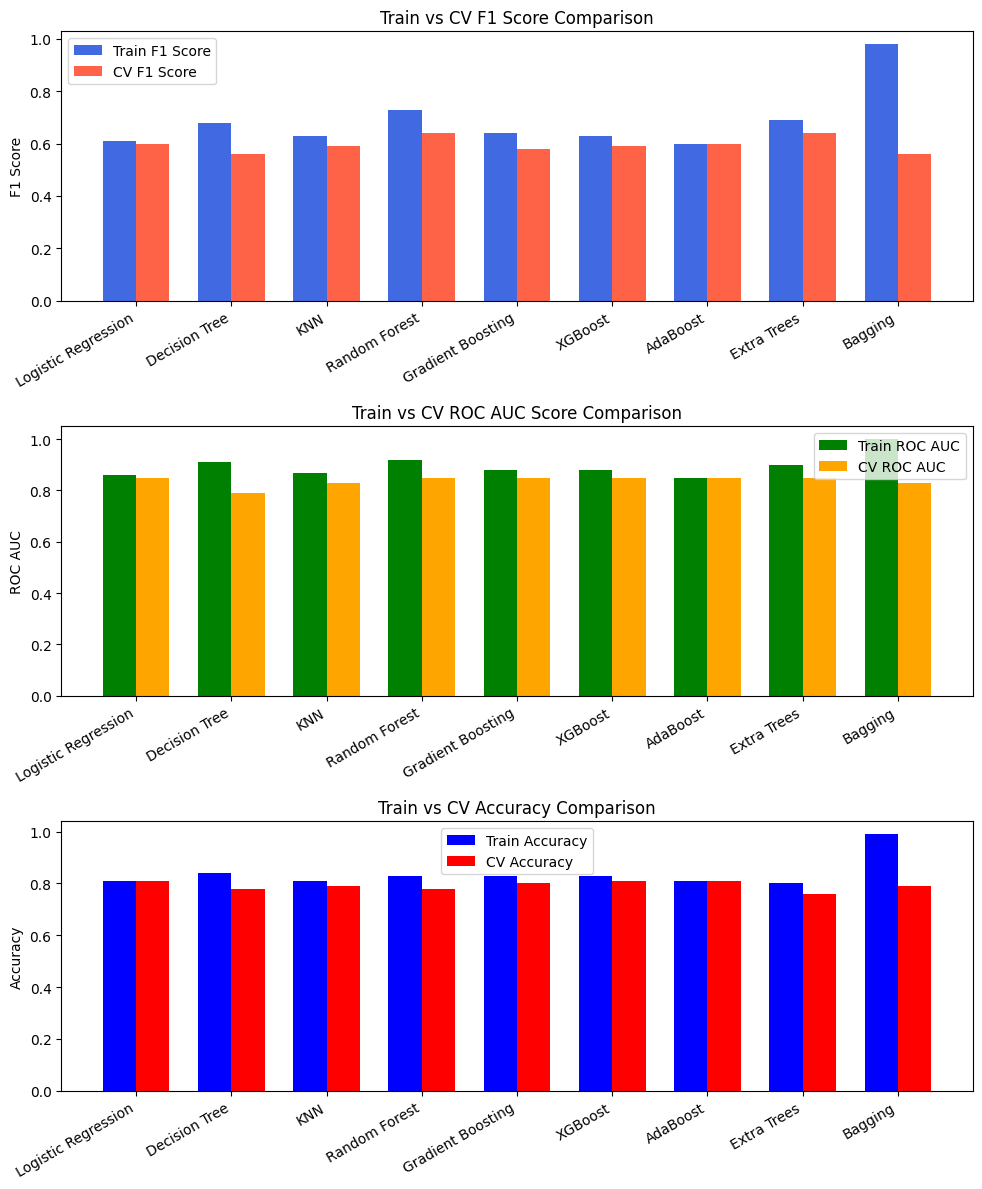

In [ ]:
plot_model_metrics(metrics)

In [ ]:
metrics_df = pd.DataFrame(metrics).T
metrics_df

,Best Parameters,Train Accuracy,CV Accuracy,Train F1 Score,CV F1 Score,Train ROC AUC,CV ROC AUC
Logistic Regression,"{'penalty': 'l2', 'max_iter': 500, 'C': 10}",0.81,0.81,0.61,0.6,0.86,0.85
Decision Tree,"{'min_samples_split': 2, 'min_samples_leaf': 2...",0.84,0.78,0.68,0.56,0.91,0.79
KNN,"{'weights': 'uniform', 'n_neighbors': 15}",0.81,0.79,0.63,0.59,0.87,0.83
Random Forest,"{'n_estimators': 150, 'min_samples_split': 14,...",0.83,0.78,0.73,0.64,0.92,0.85
Gradient Boosting,"{'n_estimators': 150, 'min_samples_split': 10,...",0.83,0.8,0.64,0.58,0.88,0.85
XGBoost,"{'subsample': 0.7, 'reg_lambda': 2, 'reg_alpha...",0.83,0.81,0.63,0.59,0.88,0.85
AdaBoost,"{'n_estimators': 100, 'learning_rate': 0.5}",0.81,0.81,0.6,0.6,0.85,0.85
Extra Trees,"{'n_estimators': 50, 'min_samples_split': 14, ...",0.8,0.76,0.69,0.64,0.9,0.85
Bagging,"{'n_estimators': 100, 'max_samples': 0.7, 'max...",0.99,0.79,0.98,0.56,1.0,0.83


ExtraTrees and Random Forest both deliver solid generalization with strong F1 and ROC AUC scores.  
They outperform the others in terms of CV metrics, which is important to prevent overfitting and ensure that the model performs well on unseen data.

## **6.2 Fine-tuning top models**.  

- (ExtraTrees & Random Forest) using Optuna

Based on initial performance, ExtraTrees and Random Forest outperformed other models. We now fine-tune their hyperparameters using Optuna to further boost F1 score.

In [ ]:
# install optuna
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 19.0 MB/s eta 0:00:00


In [ ]:
import optuna

In [ ]:
def extratrees_objective(trial, X_train, y_train):
    # Hyperparameters to tune
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.3, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = ExtraTreesClassifier(**param)

    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        f1_scores.append(f1_score(y_val_fold, y_pred))

    return sum(f1_scores) / len(f1_scores)  # average CV F1 score

In [ ]:
def tune_extratrees(X_train, y_train, n_trials=50):
    # Set seed for reproducibility
    seed = 42
    np.random.seed(seed)
    random.seed(seed)

    sampler = optuna.samplers.TPESampler(seed=seed)
    study = optuna.create_study(direction='maximize', sampler=sampler)  # Maximize F1 score

    # Optimize using the extratrees objective function
    study.optimize(lambda trial: extratrees_objective(trial, X_train, y_train), n_trials=n_trials)

    print("\n\nBest ExtraTrees Hyperparameters:", study.best_params)
    print("Best F1 Score:", study.best_value)

    return study.best_params

In [ ]:
best_extratrees_params = tune_extratrees(X_train_prep, y_train, n_trials=50)

[I 2025-04-15 09:42:00,556] A new study created in memory with name: no-name-408e323b-923c-41f9-8875-a56f5ee1e418
[I 2025-04-15 09:42:04,537] Trial 0 finished with value: 0.5732456988272345 and parameters: {'n_estimators': 106, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 0.40921304830970556, 'bootstrap': True}. Best is trial 0 with value: 0.5732456988272345.
[I 2025-04-15 09:42:12,056] Trial 1 finished with value: 0.5817489971202144 and parameters: {'n_estimators': 180, 'max_depth': 19, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 0.978936896513396, 'bootstrap': True}. Best is trial 1 with value: 0.5817489971202144.
[I 2025-04-15 09:42:15,507] Trial 2 finished with value: 0.5677776284336795 and parameters: {'n_estimators': 77, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 0.602361513049481, 'bootstrap': False}. Best is trial 1 with value: 0.5817489971202144.
[I 2025-04-15 09:42:20,000] Trial 3 fini



Best ExtraTrees Hyperparameters: {'n_estimators': 193, 'max_depth': 30, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 0.9549843306086679, 'bootstrap': True}
Best F1 Score: 0.5844997322702246


In [ ]:
def rf_objective(trial, X_train, y_train):
    # Hyperparameters to tune
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**param)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        f1_scores.append(f1_score(y_val_fold, y_pred))

    return sum(f1_scores) / len(f1_scores)

In [ ]:
def tune_rf(X_train, y_train, n_trials=50):
    study = optuna.create_study(direction='maximize')  # We want to maximize F1 score
    study.optimize(lambda trial: rf_objective(trial, X_train, y_train), n_trials=n_trials)

    # Get the best hyperparameters
    print("\n\nBest RandomForest Hyperparameters: ", study.best_params)
    print("Best F1 Score: ", study.best_value)

    return study.best_params

In [ ]:
best_rf_params = tune_rf(X_train_prep, y_train, n_trials=50)

[I 2025-04-15 09:52:38,470] A new study created in memory with name: no-name-5947ff68-cf9d-49ab-8611-969f8cedad96
[I 2025-04-15 09:52:42,472] Trial 0 finished with value: 0.6379285082087355 and parameters: {'n_estimators': 139, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'gini'}. Best is trial 0 with value: 0.6379285082087355.
[I 2025-04-15 09:52:45,641] Trial 1 finished with value: 0.6358868975368044 and parameters: {'n_estimators': 102, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini'}. Best is trial 0 with value: 0.6379285082087355.
[I 2025-04-15 09:52:48,014] Trial 2 finished with value: 0.6379885020895144 and parameters: {'n_estimators': 93, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'ba



Best RandomForest Hyperparameters:  {'n_estimators': 180, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'gini'}
Best F1 Score:  0.6433324234865561


**RandomForest is Out-Performing**

## **6.3 Further Tuning RandomForest**

In [ ]:
best_rf_params

{'n_estimators': 180,
 'max_depth': 7,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'bootstrap': False,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini'}

In [ ]:
def plot_rf_f1_scores(X_train, y_train, n_estimators_list):
    seed = 42
    np.random.seed(seed)
    random.seed(seed)

    # Initialize cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    train_f1_scores = []
    val_f1_scores = []

    # Iterate through the list of n_estimators to train and evaluate the model
    for n_estimators in n_estimators_list:
        train_f1_fold = []
        val_f1_fold = []

        # Initialize the Random Forest model with the given hyperparameters
        rf_model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=7,
            min_samples_split=5,
            min_samples_leaf=4,
            max_features='log2',
            bootstrap=False,
            class_weight='balanced_subsample',
            criterion='gini',
            random_state=42
        )

        print(f"\nTraining Random Forest with {n_estimators} estimators...")

        # Perform cross-validation
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Train the model on the training fold
            rf_model.fit(X_train_fold, y_train_fold)

            # Predict on both the train and validation folds
            y_train_pred = rf_model.predict(X_train_fold)
            y_val_pred = rf_model.predict(X_val_fold)

            # Calculate F1 scores for train and validation sets
            train_f1_fold.append(f1_score(y_train_fold, y_train_pred))
            val_f1_fold.append(f1_score(y_val_fold, y_val_pred))

        # Average F1 scores across folds
        avg_train_f1 = sum(train_f1_fold) / len(train_f1_fold)
        avg_val_f1 = sum(val_f1_fold) / len(val_f1_fold)

        train_f1_scores.append(avg_train_f1)
        val_f1_scores.append(avg_val_f1)

        # Print cross-validation results
        print(f"Avg Train F1 Score: {avg_train_f1:.4f} | Avg CV F1 Score: {avg_val_f1:.4f}")

    # Plot the train and validation F1 scores across different n_estimators
    plt.figure(figsize=(10, 6))
    plt.plot(n_estimators_list, train_f1_scores, label='Train F1 Score', marker='o', color='b')
    plt.plot(n_estimators_list, val_f1_scores, label='Validation F1 Score', marker='o', color='r')

    # Add labels and title
    plt.xlabel('Number of Estimators (n_estimators)')
    plt.ylabel('F1 Score')
    plt.title('Train and Validation F1 Scores for RandomForest')
    plt.legend()
    plt.grid(True)
    plt.show()


Training Random Forest with 160 estimators...
Avg Train F1 Score: 0.6790 | Avg CV F1 Score: 0.6420

Training Random Forest with 165 estimators...
Avg Train F1 Score: 0.6795 | Avg CV F1 Score: 0.6415

Training Random Forest with 170 estimators...
Avg Train F1 Score: 0.6797 | Avg CV F1 Score: 0.6415

Training Random Forest with 175 estimators...
Avg Train F1 Score: 0.6796 | Avg CV F1 Score: 0.6428

Training Random Forest with 180 estimators...
Avg Train F1 Score: 0.6792 | Avg CV F1 Score: 0.6433

Training Random Forest with 185 estimators...
Avg Train F1 Score: 0.6794 | Avg CV F1 Score: 0.6428

Training Random Forest with 190 estimators...
Avg Train F1 Score: 0.6790 | Avg CV F1 Score: 0.6426

Training Random Forest with 195 estimators...
Avg Train F1 Score: 0.6792 | Avg CV F1 Score: 0.6430


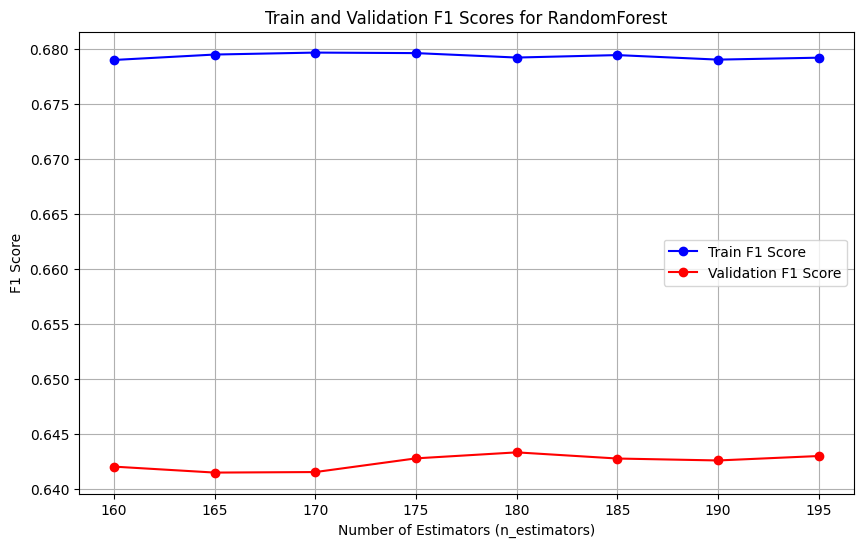

In [ ]:
n_estimators_list = np.arange(160, 200, 5)
plot_rf_f1_scores(X_train_prep, y_train, n_estimators_list)

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=180,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='log2',
    bootstrap=False,
    class_weight='balanced_subsample',
    criterion='gini',
    random_state=42
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
val_f1 = []
for train_idx, val_idx in skf.split(X_train_prep, y_train):
    X_train_fold, X_val_fold = X_train_prep.iloc[train_idx], X_train_prep.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]


    rf_model.fit(X_train_fold, y_train_fold)
    y_val_pred = rf_model.predict(X_val_fold)
    val_f1.append(f1_score(y_val_fold, y_val_pred))

print(f"Validation F1 Score: {sum(val_f1) / len(val_f1)}")

Validation F1 Score: 0.6433324234865561


In [ ]:
rf_final_model = RandomForestClassifier(
    n_estimators=180,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='log2',
    bootstrap=False,
    class_weight='balanced_subsample',
    criterion='gini',
    random_state=42
)

rf_final_model.fit(X_train_prep, y_train)
# evaluate
y_train_pred = rf_final_model.predict(X_train_prep)
y_test_pred = rf_final_model.predict(X_test_prep)

print("Train F1 Score", f1_score(y_train, y_train_pred))
print("Test F1 Score", f1_score(y_test, y_test_pred))


print("Classification Report Train Set:")
print(classification_report(y_train, y_train_pred))

print("Classification Report Test Set:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix: Train Set:")
print(confusion_matrix(y_train, y_train_pred))
print("Confusion Matrix: Test Set:")
print(confusion_matrix(y_test, y_test_pred))

Train F1 Score 0.6705788210189384
Test F1 Score 0.6150670794633643
Classification Report Train Set:
              precision    recall  f1-score   support

           0       0.93      0.76      0.84      4130
           1       0.56      0.84      0.67      1495

    accuracy                           0.78      5625
   macro avg       0.74      0.80      0.75      5625
weighted avg       0.83      0.78      0.79      5625

Classification Report Test Set:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1033
           1       0.50      0.80      0.62       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.80      0.73      0.75      1407

Confusion Matrix: Train Set:
[[3133  997]
 [ 238 1257]]
Confusion Matrix: Test Set:
[[736 297]
 [ 76 298]]


In [22]:
def evaluate_confusion_matrix(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    metrices = {}
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    cm = confusion_matrix(y_train, y_train_pred)
    ConfusionMatrixDisplay(cm).plot(ax=axes[0], cmap="viridis")
    axes[0].set_title(f"Confusion Matrix (Train Set)")
    axes[0].set_xlabel("Predicted Label", fontsize=12)
    axes[0].set_ylabel("True Label", fontsize=12)

    cm = confusion_matrix(y_test, y_test_pred)
    ConfusionMatrixDisplay(cm).plot(ax=axes[1], cmap="viridis")
    axes[1].set_title(f"Confusion Matrix (Test Set)")
    axes[1].set_xlabel("Predicted Label", fontsize=12)
    axes[1].set_ylabel("True Label", fontsize=12)
    plt.tight_layout()
    plt.show()

    metrices['Train Metrics'] = {
        'Precision': precision_score(y_train, y_train_pred),
        'Recall': recall_score(y_train, y_train_pred),
        'F1 Score': f1_score(y_train, y_train_pred),
        'Accuracy': accuracy_score(y_train, y_train_pred)
    }

    metrices['Test Metrics'] = {
        'Precision': precision_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'F1 Score': f1_score(y_test, y_test_pred),
        'Accuracy': accuracy_score(y_test, y_test_pred)
    }
    return metrices

In [23]:
def plot_roc_auc_curve(model, X, y, dataset_name, axs):
    # ROC Curve
    disp = RocCurveDisplay.from_estimator(model, X, y, ax=axs, alpha=0.8)
    axs.plot([0, 1], [0, 1], linestyle="--", color="gray")
    axs.set_title(f"ROC Curve ({dataset_name} Set)")
    axs.set_xlabel("False Positive Rate")
    axs.set_ylabel("True Positive Rate")
    axs.legend()
    return disp

In [24]:
def plot_curves(model, X_train, y_train, X_test, y_test):
    fig, axes = plt.subplots(1, 2, figsize=(8,6))
    axs = axes.ravel()

    plot_roc_auc_curve(model, X_train, y_train, "Train", axs[0])
    plot_roc_auc_curve(model, X_test, y_test, "Test", axs[1])

    plt.tight_layout()
    plt.show()

In [25]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    metrics = evaluate_confusion_matrix(model, X_train, y_train, X_test, y_test)
    plot_curves(model, X_train, y_train, X_test, y_test)

    return metrics

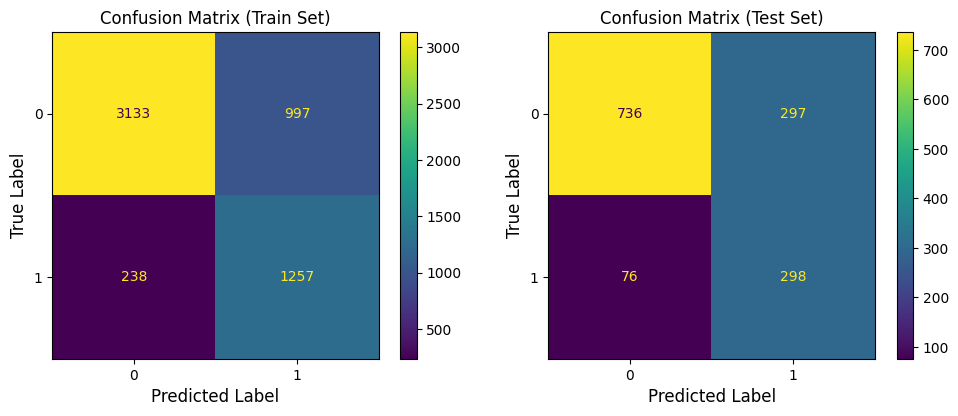

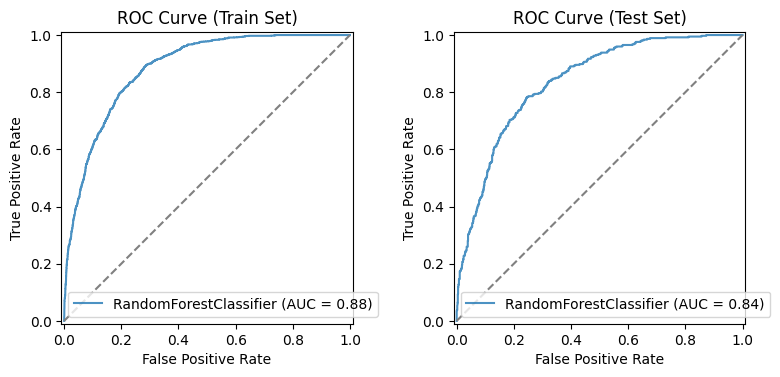

In [ ]:
metrics_rf_final_model = evaluate_model(rf_final_model, X_train_prep, y_train, X_test_prep, y_test)

In [ ]:
# metrics df
metrics_rf_final_model = pd.DataFrame(metrics_rf_final_model).T
metrics_rf_final_model

,Precision,Recall,F1 Score,Accuracy
Train Metrics,0.557675,0.840803,0.670579,0.780444
Test Metrics,0.500840,0.796791,0.615067,0.734897


## **6.4 Performance with Feature Selection**

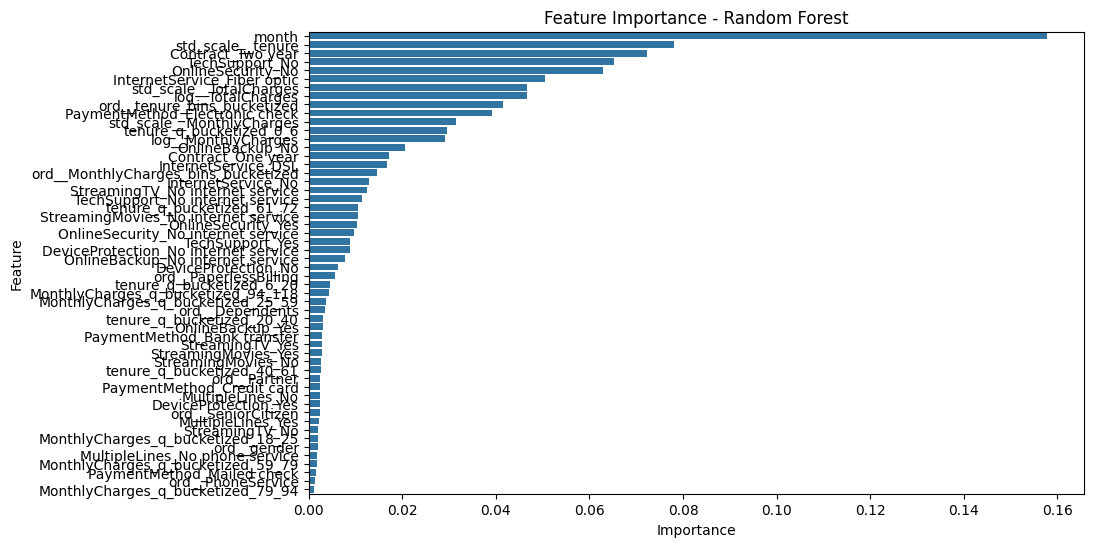

In [ ]:
def feature_imp(model, X_train_prep):
    feat_imp = model.feature_importances_
    feat_df = pd.DataFrame({
        "Feature": X_train_prep.columns,
        "Importance": feat_imp
    })
    feat_df = feat_df.sort_values(by="Importance", ascending=False).reset_index(drop=True)

    feat_df["Cumulative Importance"] = feat_df["Importance"].cumsum()
    # Plot
    plt.figure(figsize=(10,6))
    sns.barplot(x="Importance", y="Feature", data=feat_df)
    plt.title("Feature Importance - Random Forest")
    plt.show()
    return feat_df

feat_df = feature_imp(rf_final_model, X_train_prep)

In [ ]:
feat_df

,Feature,Importance,Cumulative Importance
0,month,0.157714,0.157714
1,std_scale__tenure,0.078170,0.235884
2,Contract_Two year,0.072228,0.308112
3,TechSupport_No,0.065177,0.373289
4,OnlineSecurity_No,0.062940,0.436229
5,InternetService_Fiber optic,0.050486,0.486715
6,std_scale__TotalCharges,0.046676,0.533391
7,log__TotalCharges,0.046624,0.580014
8,ord__tenure_bins_bucketized,0.041521,0.621535
9,PaymentMethod_Electronic check,0.039235,0.660770


In [ ]:
def plot_cv_f1_by_feat_importance_threshold(X_train, y_train, feat_df, thresholds):
    seed = 42
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    f1_scores_by_thresh = []
    feature_counts = []

    print("\nEvaluating F1 Scores across cumulative importance thresholds...\n")

    for thresh in thresholds:
        selected_features = feat_df[feat_df["Cumulative Importance"] <= thresh]["Feature"].tolist()
        X_train_reduced = X_train[selected_features]
        f1_fold_scores = []

        for train_idx, val_idx in skf.split(X_train_reduced, y_train):
            X_tr, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            model = RandomForestClassifier(
                n_estimators=180,
                max_depth=7,
                min_samples_split=5,
                min_samples_leaf=4,
                max_features='log2',
                bootstrap=False,
                class_weight='balanced_subsample',
                criterion='gini',
                random_state=seed,
                n_jobs=-1
            )

            model.fit(X_tr, y_tr)
            y_val_pred = model.predict(X_val)
            f1_fold_scores.append(f1_score(y_val, y_val_pred))

        avg_f1 = sum(f1_fold_scores) / len(f1_fold_scores)
        f1_scores_by_thresh.append(avg_f1)
        feature_counts.append(len(selected_features))

        print(f"Threshold = {thresh:.2f} | Features kept = {len(selected_features):2d} | CV F1 Score = {avg_f1:.4f}")

    # Plotting
    plt.figure(figsize=(8, 6))

    plt.plot(thresholds, f1_scores_by_thresh, marker='o', color='teal')
    plt.title('CV F1 Score vs. Cumulative Feature Importance Threshold')
    plt.xlabel('Cumulative Importance Threshold (%)')
    plt.ylabel('Average CV F1 Score')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional return for logging or saving
    results_df = pd.DataFrame({
        'Threshold': thresholds,
        'Num Features': feature_counts,
        'CV F1 Score': f1_scores_by_thresh
    })

    return results_df


Evaluating F1 Scores across cumulative importance thresholds...

Threshold = 0.90 | Features kept = 24 | CV F1 Score = 0.6391
Threshold = 0.92 | Features kept = 26 | CV F1 Score = 0.6405
Threshold = 0.94 | Features kept = 30 | CV F1 Score = 0.6407
Threshold = 0.96 | Features kept = 35 | CV F1 Score = 0.6399
Threshold = 0.98 | Features kept = 43 | CV F1 Score = 0.6409
Threshold = 0.99 | Features kept = 47 | CV F1 Score = 0.6391


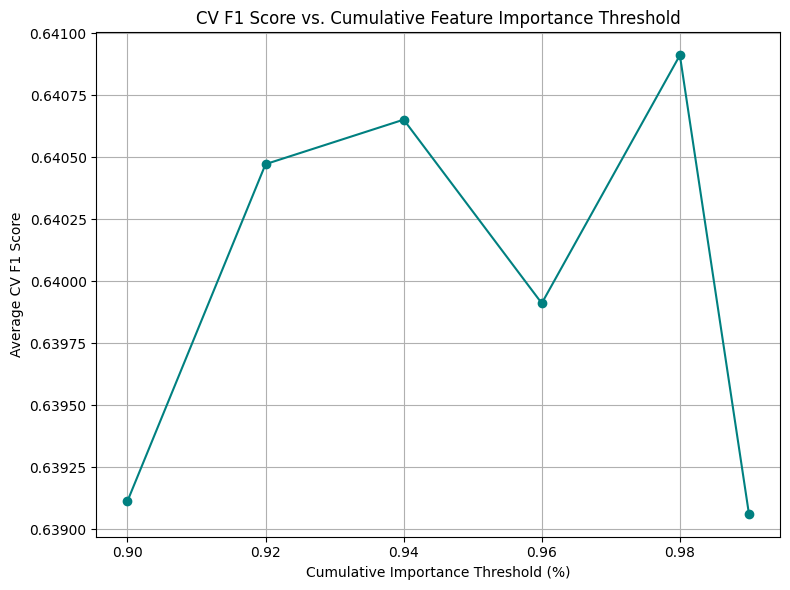

In [ ]:
thresholds = [0.90, 0.92, 0.94, 0.96, 0.98, 0.99]
results_df = plot_cv_f1_by_feat_importance_threshold(X_train_prep, y_train, feat_df, thresholds)

In [ ]:
# selected and dropped features names
def get_selected_and_dropped_features(feat_df, thresh=0.90):
    selected_features = feat_df[feat_df["Cumulative Importance"] <= thresh]["Feature"].tolist()

    dropped_features = feat_df[~feat_df["Feature"].isin(selected_features)]["Feature"].tolist()

    print(f"Selected ({len(selected_features)} features):")
    print(selected_features)

    print(f"\nDropped ({len(dropped_features)} features):")
    print(dropped_features)

    return selected_features, dropped_features

In [ ]:
selected_features, dropped_features = get_selected_and_dropped_features(feat_df, thresh=0.98)

Selected (43 features):
['month', 'std_scale__tenure', 'Contract_Two year', 'TechSupport_No', 'OnlineSecurity_No', 'InternetService_Fiber optic', 'std_scale__TotalCharges', 'log__TotalCharges', 'ord__tenure_bins_bucketized', 'PaymentMethod_Electronic check', 'std_scale__MonthlyCharges', 'tenure_q_bucketized_0_6', 'log__MonthlyCharges', 'OnlineBackup_No', 'Contract_One year', 'InternetService_DSL', 'ord__MonthlyCharges_bins_bucketized', 'InternetService_No', 'StreamingTV_No internet service', 'TechSupport_No internet service', 'tenure_q_bucketized_61_72', 'StreamingMovies_No internet service', 'OnlineSecurity_Yes', 'OnlineSecurity_No internet service', 'TechSupport_Yes', 'DeviceProtection_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No', 'ord__PaperlessBilling', 'tenure_q_bucketized_6_20', 'MonthlyCharges_q_bucketized_94_118', 'MonthlyCharges_q_bucketized_25_59', 'ord__Dependents', 'tenure_q_bucketized_20_40', 'OnlineBackup_Yes', 'PaymentMethod_Bank transf

In [ ]:
# thresh = 0.98
selected_features = feat_df[feat_df["Cumulative Importance"] <= 0.98]["Feature"].tolist()
print('Selected Features:', len(selected_features))
X_train_prep_reduced = X_train_prep[selected_features]
X_test_prep_reduced = X_test_prep[selected_features]

rf_final_model_feat_sel = RandomForestClassifier(
    n_estimators=180,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='log2',
    bootstrap=False,
    class_weight='balanced_subsample',
    criterion='gini',
    random_state=42
)

rf_final_model_feat_sel.fit(X_train_prep_reduced, y_train)

Selected Features: 43


RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       max_depth=7, max_features='log2', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=180, random_state=42)

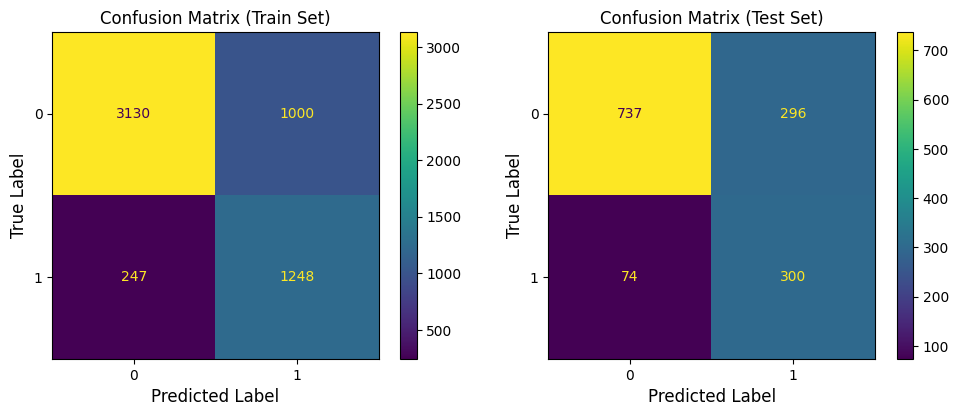

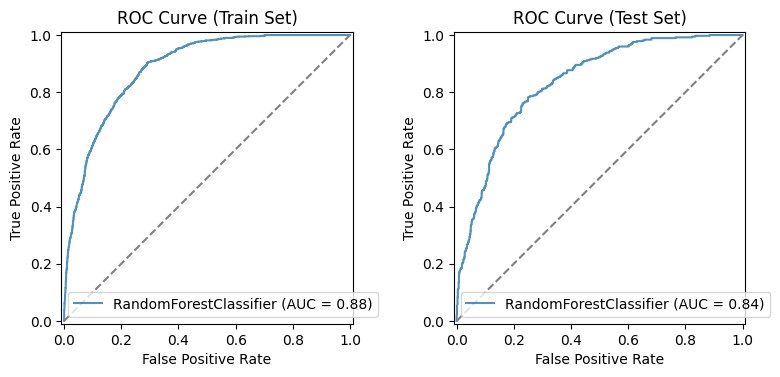

In [ ]:
metrics_rf_final_model_feat_sel = evaluate_model(rf_final_model_feat_sel, X_train_prep_reduced, y_train, X_test_prep_reduced, y_test)

In [ ]:
metrics_rf_final_model_feat_sel = pd.DataFrame(metrics_rf_final_model_feat_sel).T

print("Before Feature Selection:")
print(metrics_rf_final_model)
print("-" * 50)
print("\nAfter Feature Selection:")
print(metrics_rf_final_model_feat_sel)

Before Feature Selection:
               Precision    Recall  F1 Score  Accuracy
Train Metrics   0.557675  0.840803  0.670579  0.780444
Test Metrics    0.500840  0.796791  0.615067  0.734897
--------------------------------------------------

After Feature Selection:
               Precision    Recall  F1 Score  Accuracy
Train Metrics   0.555160  0.834783  0.666845  0.778311
Test Metrics    0.503356  0.802139  0.618557  0.737029


Feature Selection has improved performance and addressed overfitting.

## **6.5 Performance After Droping Features**  
- Droping Features that found unimportant or redundant during EDA.

In [ ]:
removeable_features_dict

[{'Feature': 'TotalCharges',
  'Reason': 'Highly Correlated with Tenure, VIF = 8.16',
  'Additional Info': 'TotalCharges = MonthlyCharges * Tenure'},
 {'Feature': 'gender',
  'Reason': 'Chi-square test (p-value = 0.68186): No significant relationship with target',
  'Additional Info': None},
 {'Feature': 'PhoneService',
  'Reason': 'Chi-square test (p-value = 0.5171): No significant relationship with target',
  'Additional Info': None},
 {'Feature': ['PaperlessBilling',
   'Dependents',
   'Partner',
   'SeniorCitizen',
   'MultipleLines',
   'PhoneService',
   'gender'],
  'Reason': 'Mutual Information with target < 0.025: Low relevance',
  'Additional Info': None},
 {'Feature': 'MonthlyCharges_q_bucketized',
  'Reason': 'High MI = 0.97 with MonthlyCharges_bins_bucketized',
  'Additional Info': 'Redundant'},
 {'Feature': 'tenure_q_bucketized',
  'Reason': 'High MI = 0.84 with tenure_bins_bucketized',
  'Additional Info': 'Redundant'},
 {'Feature': 'InternetService',
  'Reason': 'High 

In [ ]:
feature_names = [
    'TotalCharges',
    'gender',
    'PhoneService',
    'PaperlessBilling',
    'Dependents',
    'Partner',
    'SeniorCitizen',
    'MultipleLines',
    'MonthlyCharges_q_bucketized',
    'tenure_q_bucketized',
    'InternetService'
]
len(feature_names)

11

In [ ]:
# Remove features that are in feature_names for each list
num_features_filtered = [feature for feature in num_features if feature not in feature_names]
num_f_log_scale_filtered = [feature for feature in num_f_log_scale if feature not in feature_names]
cat_f_1h_filtered = [feature for feature in cat_f_1h if feature not in feature_names]
cat_f_ord_filtered = [feature for feature in cat_f_ord if feature not in feature_names]
cat_ordinal_orders_filtered = {key: value for key, value in cat_ordinal_orders.items() if key not in feature_names}

In [ ]:
X_train_feat_rem = X_train.drop(columns=feature_names)
X_test_feat_rem = X_test.drop(columns=feature_names)
# Shape
print(X_train_feat_rem.shape)

(5625, 12)


In [ ]:
pipeline_feat_rem = create_preprocessing_pipeline(
    num_features_filtered,
    num_f_log_scale_filtered,
    cat_f_1h_filtered,
    cat_f_ord_filtered,
    cat_ordinal_orders_filtered
)

X_train_feat_rem_prep = pipeline_feat_rem.fit_transform(X_train_feat_rem)
X_test_feat_rem_prep = pipeline_feat_rem.transform(X_test_feat_rem)

print(X_train_feat_rem_prep.shape)

(5625, 30)


In [ ]:
rf_final_model_feat_rem = RandomForestClassifier(
    n_estimators=180,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='log2',
    bootstrap=False,
    class_weight='balanced_subsample',
    criterion='gini',
    random_state=42
)

rf_final_model_feat_rem.fit(X_train_feat_rem_prep, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       max_depth=7, max_features='log2', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=180, random_state=42)

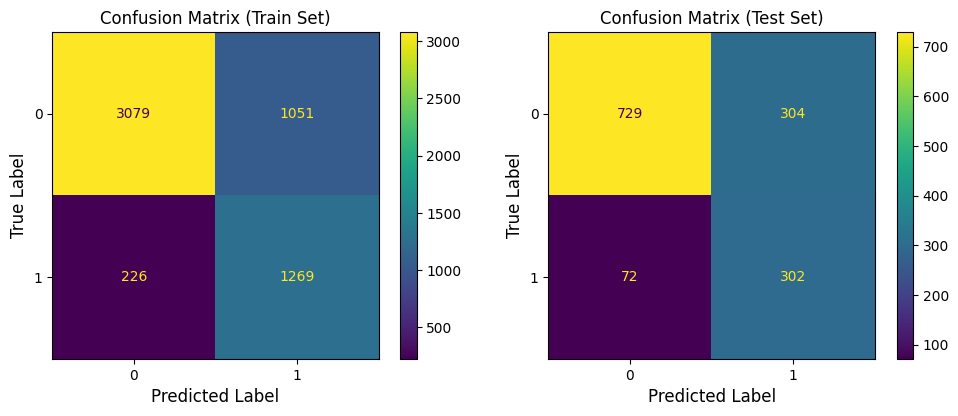

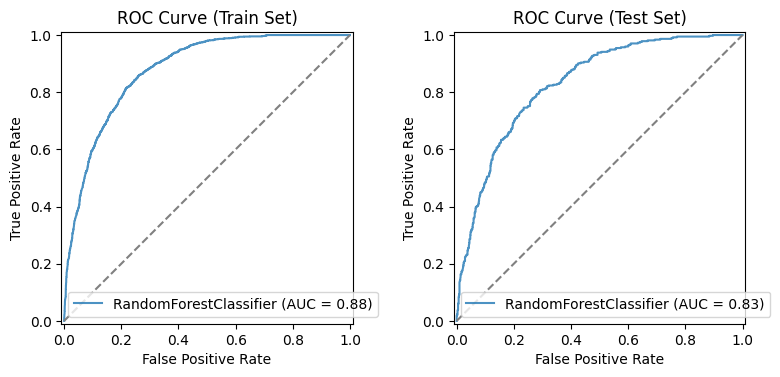

In [ ]:
metrics_rf_final_model_feat_rem = evaluate_model(rf_final_model_feat_rem, X_train_feat_rem_prep, y_train, X_test_feat_rem_prep, y_test)

In [ ]:
metrics_rf_final_model_feat_rem = pd.DataFrame(metrics_rf_final_model_feat_rem).T

In [ ]:
# Comparision
print("Before Feature Selection and Removal:")
print(metrics_rf_final_model)
print("-" * 50)
print("\nAfter Feature Selection:")
print(metrics_rf_final_model_feat_sel)
print("-" * 50)
print("\nAfter Feature Removal:")
print(metrics_rf_final_model_feat_rem)

Before Feature Selection and Removal:
               Precision    Recall  F1 Score  Accuracy
Train Metrics   0.557675  0.840803  0.670579  0.780444
Test Metrics    0.500840  0.796791  0.615067  0.734897
--------------------------------------------------

After Feature Selection:
               Precision    Recall  F1 Score  Accuracy
Train Metrics   0.555160  0.834783  0.666845  0.778311
Test Metrics    0.503356  0.802139  0.618557  0.737029
--------------------------------------------------

After Feature Removal:
               Precision    Recall  F1 Score  Accuracy
Train Metrics   0.546983  0.848829  0.665269  0.772978
Test Metrics    0.498350  0.807487  0.616327  0.732765


## **6.6 Performance On Feature Droping and Selection**

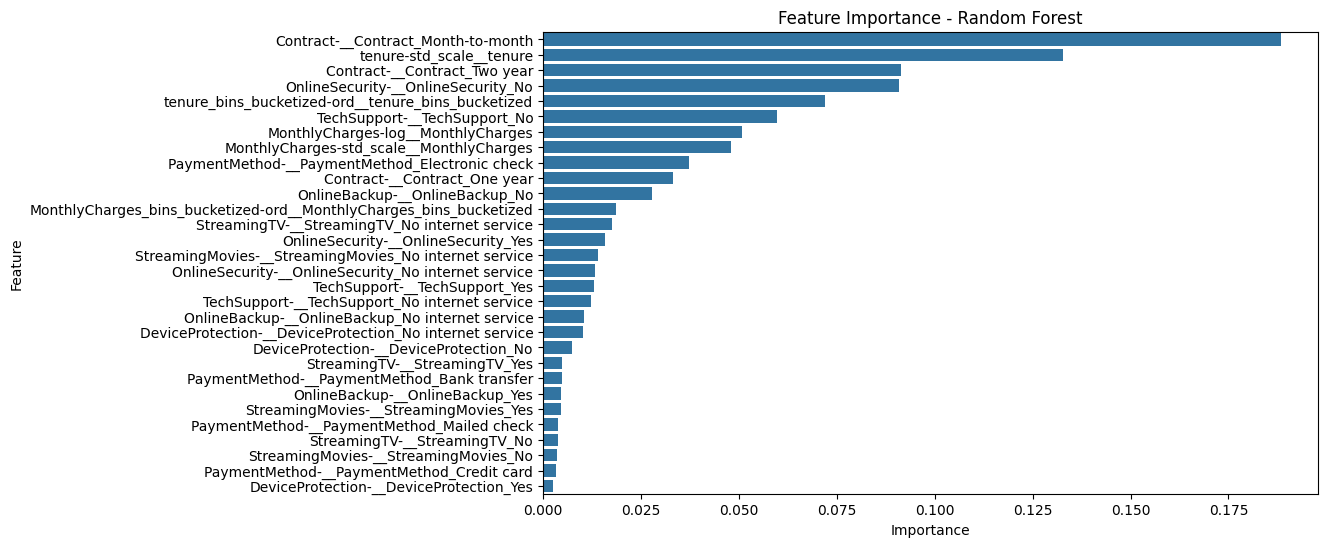

In [ ]:
feat_df_rem = feature_imp(rf_final_model_feat_rem, X_train_feat_rem_prep)

In [ ]:
# thresh = 0.98
selected_features = feat_df_rem[feat_df_rem["Cumulative Importance"] <= 0.98]["Feature"].tolist()
print('Selected Features:', len(selected_features))
X_train_feat_rem_prep_reduced = X_train_feat_rem_prep[selected_features]
X_test_feat_rem_prep_reduced = X_test_feat_rem_prep[selected_features]

rf_final_model_feat_rem_sel = RandomForestClassifier(
    n_estimators=180,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='log2',
    bootstrap=False,
    class_weight='balanced_subsample',
    criterion='gini',
    random_state=42
)

rf_final_model_feat_rem_sel.fit(X_train_feat_rem_prep_reduced, y_train)

Selected Features: 24


RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       max_depth=7, max_features='log2', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=180, random_state=42)

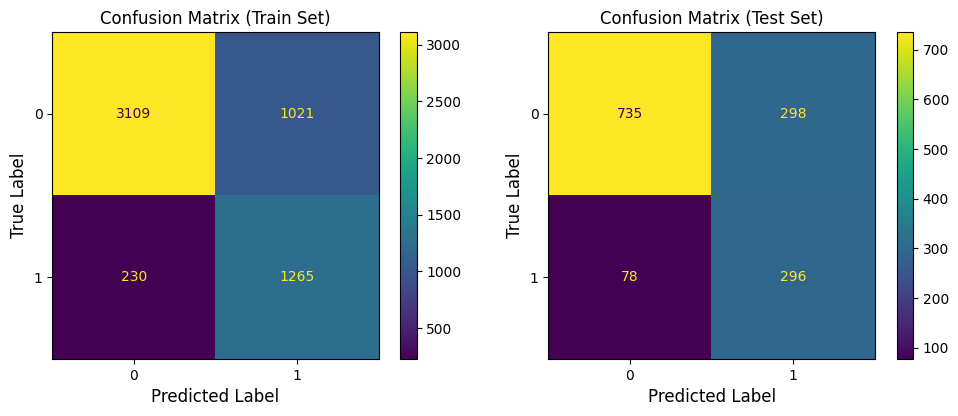

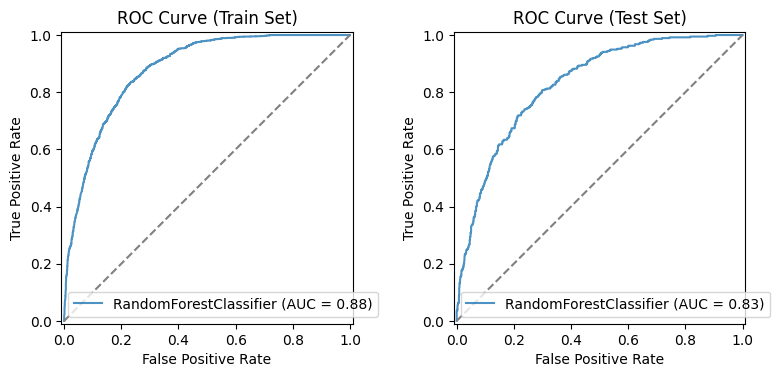

In [ ]:
metrics_rf_final_model_feat_rem_sel = evaluate_model(rf_final_model_feat_rem_sel, X_train_feat_rem_prep_reduced, y_train, X_test_feat_rem_prep_reduced, y_test)

In [ ]:
metrics_rf_final_model_feat_rem_sel = pd.DataFrame(metrics_rf_final_model_feat_rem_sel).T

In [ ]:
# Comparision
print("Before Feature Selection and Removal:")
print(metrics_rf_final_model)
print("-" * 50)
print("\nAfter Feature Selection:")
print(metrics_rf_final_model_feat_sel)
print("-" * 50)
print("\nAfter Feature Removal:")
print(metrics_rf_final_model_feat_rem)
print("-" * 50)
print("\nAfter Feature Selection and Removal:")
print(metrics_rf_final_model_feat_rem_sel)

Before Feature Selection and Removal:
               Precision    Recall  F1 Score  Accuracy
Train Metrics   0.557675  0.840803  0.670579  0.780444
Test Metrics    0.500840  0.796791  0.615067  0.734897
--------------------------------------------------

After Feature Selection:
               Precision    Recall  F1 Score  Accuracy
Train Metrics   0.555160  0.834783  0.666845  0.778311
Test Metrics    0.503356  0.802139  0.618557  0.737029
--------------------------------------------------

After Feature Removal:
               Precision    Recall  F1 Score  Accuracy
Train Metrics   0.546983  0.848829  0.665269  0.772978
Test Metrics    0.498350  0.807487  0.616327  0.732765
--------------------------------------------------

After Feature Selection and Removal:
               Precision    Recall  F1 Score  Accuracy
Train Metrics   0.553368  0.846154  0.669135  0.777600
Test Metrics    0.498316  0.791444  0.611570  0.732765


**Best is just to do feature selection**

## **6.7 Final Model**:  
`rf_final_model_feat_sel`

In [ ]:
display(metrics_rf_final_model_feat_sel)
params = rf_final_model_feat_sel.get_params()
display(params)

,Precision,Recall,F1 Score,Accuracy
Train Metrics,0.555160,0.834783,0.666845,0.778311
Test Metrics,0.503356,0.802139,0.618557,0.737029


{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 180,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [18]:
# Load Data
X_trian, X_test, y_train, y_test = load_data()

X_train shape: (5625, 23)
y_train shape: (5625,)
X_test shape: (1407, 23)
y_test shape: (1407,)


In [19]:
model = RandomForestClassifier(
    n_estimators=180,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='log2',
    bootstrap=False,
    class_weight='balanced_subsample',
    criterion='gini',
    random_state=42
)

preprocessing = create_preprocessing_pipeline(
    num_f_scale,
    num_f_log_scale,
    cat_f_1h,
    cat_f_ord,
    cat_ordinal_orders
)

def clean_column_names(X):
    X.columns = X.columns.map(lambda x: x.split('-')[-1])
    X.columns = X.columns.str.lstrip('_')
    return X

rename_columns_transformer = FunctionTransformer(clean_column_names, validate=False)

features_to_drop = [
    'DeviceProtection_Yes', 'ord__SeniorCitizen', 'MultipleLines_Yes', 'StreamingTV_No',
    'MonthlyCharges_q_bucketized_18_25', 'ord__gender', 'MultipleLines_No phone service',
    'MonthlyCharges_q_bucketized_59_79', 'PaymentMethod_Mailed check', 'ord__PhoneService',
    'MonthlyCharges_q_bucketized_79_94'
]

# FunctionTransformer to drop columns
drop_features_transformer = FunctionTransformer(
    lambda X: X.drop(columns=[f for f in features_to_drop if f in X.columns]),
    validate=False
)

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('rename_columns', rename_columns_transformer),
    ('drop_features', drop_features_transformer),
    ('model', model)
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('tenure-std_scale',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['tenure']),
                                                 ('MonthlyCharges-std_scale',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyCharge...
                ('rename_columns',
                 FunctionTransformer(func=<function clean_column_names at 0x7e2294c5f420>)),
                ('drop_features',
                 FunctionTransformer(func=<function <lambda> at 0x7e2294c5f560>)),
                ('model',
                 RandomForestClassifier(bootstrap=False,
                                        class_weight='balanced_subsample',
                                        max_depth=7, max_features='log2',
                                        min_samples_leaf=4, min_samples_split=5,
                                        n_estimators=180, random_state=42))])

In [20]:
# Features
X_preprocessed = pipeline.named_steps['drop_features'].transform(
    pipeline.named_steps['rename_columns'].transform(
        pipeline.named_steps['preprocessing'].transform(X_train)
    )
)

final_feature_names = X_preprocessed.columns.tolist()

print(f"Final Features Used {len(final_feature_names)}:")
print(final_feature_names)

Final Features Used 43:
['std_scale__tenure', 'std_scale__MonthlyCharges', 'std_scale__TotalCharges', 'log__MonthlyCharges', 'log__TotalCharges', 'MultipleLines_No', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_No internet service', 'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer', 'PaymentMethod_Credit card', 'PaymentMethod_Electronic check', 'MonthlyCharges_q_bucketized_25_59', 'MonthlyCharges_q_bucketized_94_118', 'tenure_q_bucketized_0_6', 'tenure_q_bucketized_20_40', 'tenure_q_bucketized_40_61', 'tenure_q_bucketized_61_

**Performance**

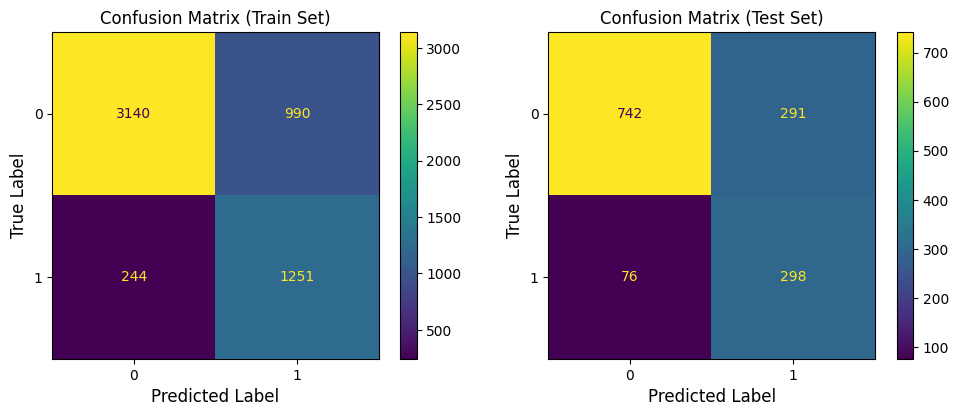

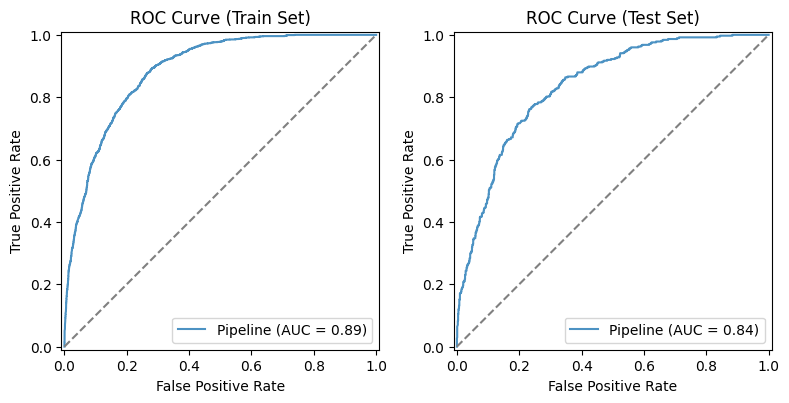

In [26]:
metrics_rf_model_pipeline = evaluate_model(pipeline, X_train, y_train, X_test, y_test)

In [ ]:
metrics_rf_model_pipeline_df = pd.DataFrame(metrics_rf_model_pipeline).T
metrics_rf_model_pipeline_df

,Precision,Recall,F1 Score,Accuracy
Train Metrics,0.558233,0.836789,0.669700,0.780622
Test Metrics,0.505942,0.796791,0.618899,0.739161


## **6.8 Save Pipeline**

In [27]:
import os
import cloudpickle

folder_path = '/content/drive/MyDrive/Colab Notebooks/Customer_Churn_Prediction/model/'
os.makedirs(folder_path, exist_ok=True)

with open(folder_path + 'model_pipeline.pkl', "wb") as f:
    cloudpickle.dump(pipeline, f)

print(f"Saved successfully at {folder_path}")

Saved successfully at /content/drive/MyDrive/Colab Notebooks/Customer_Churn_Prediction/model/


# **7 Load and Make Prediction on Test Set**

In [28]:
# Load data
X_trian, X_test, y_train, y_test = load_data()

X_train shape: (5625, 23)
y_train shape: (5625,)
X_test shape: (1407, 23)
y_test shape: (1407,)


In [31]:
# Load Pipeline
import cloudpickle

folder_path = '/content/drive/MyDrive/Colab Notebooks/Customer_Churn_Prediction/model/'
# folder_path = 'model/'

with open(folder_path + 'model_pipeline.pkl', "rb") as f:
    loaded_pipeline = cloudpickle.load(f)

In [30]:
y_test_pred = loaded_pipeline.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
df.head(20)

,Actual,Predicted
0,0,0
1,0,1
2,0,0
3,1,0
4,0,0
5,1,1
6,0,0
7,0,0
8,1,1
9,0,0
